In [11]:
import os
import re
import sys
import time
import shutil
import copy
import glob
import numpy as np
import itertools
import importlib
import multiprocessing
import multiprocessing.pool

import segyio
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from skimage import restoration
from scipy import signal, ndimage
from natsort import natsorted
import seaborn as sns

import mgen
import datasetmaker
import shared as sd
import loaders as ld
import vis
from IPython.display import clear_output

# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../'))
import pyapi_denise as api
print(f'Python: {sys.prefix}')

Python: /home/plotnips/anaconda3/envs/torch2


In [12]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 150,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [13]:
root_fwi = './out_ac/'
root_out = '/data/oleg/data/'
root_field = os.path.join('./data_cgg/')
nmodels = 16
# benchmark_marm = True

In [14]:
# Time sampling in ML application
dt_net = 0.016

In [15]:
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True

def divmax(x): return x / np.max(np.abs(x))
    
def load_bin(p, dims): 
    f = open(p); vp = np.fromfile (f, dtype=np.dtype('float32').newbyteorder ('<')); f.close();
    vp = vp.reshape(*dims); vp = np.transpose(vp); vp = np.flipud(vp); print(f"{vp.shape}"); return vp

def plot_model(v, title='', axis='on', **kwargs): 
    plt.figure(); ax = plt.gca(); im = ax.imshow(np.flipud(v), cmap='RdBu_r', **kwargs); plt.axis(axis); plt.title(title); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);plt.colorbar(im, cax=cax); plt.pause(0.001)
    return ax

def plot_logs(m1, m2, idx=2, title=''):
    plt.figure(); plt.plot(m1.vp[::-1,idx], 'k--'); plt.plot(m1.vs[::-1,idx], 'k--'); plt.plot(m1.rho[::-1,idx], 'k--');
    plt.plot(m2.vp[::-1,idx], label='vp'); plt.plot(m2.vs[::-1,idx], label='vs'); plt.plot(m2.rho[::-1,idx], label='rho'); plt.legend() 

# Load initial model

In [16]:
dx = 12.5
vp, _ = ld.load_hh(os.path.join(root_field, 'cgg_tomo.hh'), 1)
vp = np.flipud(vp.T)[::1, ::1] * 1000

# Downsample
factor = 2
ndown = 10
dx = dx * factor
vp = vp[::factor, ::factor]
vp = vp[:-ndown, :]

vis.plot_model(vp)
print(vp.shape)

Load ./data_cgg/cgg_tomo.hh
	dim: 2
	dict['n1'] <-- n1 <-- 300
	dict['d1'] <-- d1 <-- 12.5
	dict['o1'] <-- o1 <-- 0
	dict['n2'] <-- n2 <-- 1000
	dict['d2'] <-- d2 <-- 12.5
	dict['o2'] <-- o2 <-- 0
	data <-- (300, 1000)
(140, 500)


In [17]:
def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x

ndeeper = 2
nexp = 100
vp_cgg = extend(vp, ndeeper, 0)
vp_cgg = np.concatenate((np.flip(vp_cgg[:ndown, :], 0), vp_cgg), 0)  # OZ
vp_cgg = np.where(vp_cgg < 1490.0, 1490.0, vp_cgg)
tmp = extend(vp_cgg, 0, nexp)

taper0 = tmp[:,:500] < 1.01 * np.min(tmp[:,:500])

# tmp = extend(vp, ndeeper, 0)
print(tmp.shape)
vis.plot_model(tmp)
vp = tmp.copy()
nz0, nx0 = vp.shape
print(nz0, nx0)
print(taper0.shape)
print(vp_cgg.min())

(152, 600)
152 600
(152, 500)
1490.0


# Well-log model

In [18]:
lvp, _ = ld.load_hh(os.path.join(root_field, 'cgg_log.hh'), 1)
lvp = np.flipud(lvp.T)

lvp = lvp[::factor, :]
lvp = lvp[:-5, :nx0]
print(lvp.shape)

# shear velocity, [m/s]
lvs = lvp.copy() / (3 ** 0.5)
lvs = np.where(lvp < 1.01 * np.min(lvp), 0, lvs)

# density, [kg/m3] 
lrho = 1e3*0.3 * lvp.copy()**0.25
lrho = np.where(lvp < 1.01 * np.min(lvp), 1000, lrho)
model_log = api.Model(lvp, lvs, lrho, dx)

Load ./data_cgg/cgg_log.hh
	dim: 2
	dict['n1'] <-- n1 <-- 241
	dict['d1'] <-- d1 <-- 12.5
	dict['o1'] <-- o1 <-- 0
	dict['n2'] <-- n2 <-- 800
	dict['d2'] <-- d2 <-- 12.5
	dict['o2'] <-- o2 <-- 0
	data <-- (241, 800)
(116, 600)


In [19]:
log_loc = 10500 # m
log_idx = int(10500 / dx)
# plot_logs(model_log, model_cgg, log_idx, title='Initial vs well-log')

In [20]:
# # model = api.Model(vp, vs, rho, dx)
# model = copy.deepcopy(model_cgg)
# print(model)

# nz, nx = vp.shape
# vplim = {'vmax': model.vp.max()/1000, 'vmin': model.vp.min()/1000}
# vslim = {'vmax': model.vs.max()/1000, 'vmin': model.vs.min()/1000}
# rholim = {'vmax': model.rho.max()/1000, 'vmin': model.rho.min()/1000}
# vlims = {'vp': vplim, 'vs': vslim, 'rho': rholim}
# print(f'size:\t{(nz,nx)}\nvp:\t{vplim}\nvs:\t{vslim}\nrho:\t{rholim}')

# Data

In [21]:
filename = '/home/ovcharoo/Dropbox/swag_datasets/CGG_NW_Australia/bdata.segy'

In [22]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the segy file trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    One row per trace
    '''
    # Get all header keys
    headers = segyio.tracefield.keys
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces + 1),
                      columns=headers.keys())
    # Fill dataframe with all header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
    return df


def parse_text_header(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1::]
    # Remove end of line return
    text_header = [x.replace('\n', ' ') for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header[key] = item
    return clean_header

In [23]:
# Parsing 15 Gb data, takes some time!
hname = os.path.join(root_field, 'trace_headers.pkl')
trace_headers = sd.load_object(hname)

# if trace_headers is None:
#     t1 = time.time()
#     with segyio.open(filename, ignore_geometry=True) as f:
#         # Get basic attributes
#         n_traces = f.tracecount
#     #     sample_rate = segyio.tools.dt(f) / 1000
#     #     n_samples = f.samples.size
#     #     twt = f.samples
#     #     data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
#         # Load headers
#         bin_headers = f.bin
#     #     text_headers = parse_text_header(f)
#         trace_headers = parse_trace_headers(f, n_traces)

if trace_headers is None:
    t1 = time.time()
    with segyio.open(filename, ignore_geometry=True) as f:
        n_traces = f.tracecount
        trace_headers = parse_trace_headers(f, n_traces)
    save_object(trace_headers, hname)
    print(f'Elapsed time: {time.time() - t1} sec')

Load obj from ./data_cgg/trace_headers.pkl


Creating a segy file is a headache. Have to fill in filelds in segyio.spec() to send it as second argument in segyio.create(fname, spec)

In [24]:
with segyio.open(filename, ignore_geometry=True) as f:
    print('\n'.join([str(s) for s in [f.sorting, 
                                      f.format, 
                                      f.samples.shape,
                                     f.ilines,
                                     f.xlines,
                                     f.tracecount,
#                                      f.text[0],
                                     f.header]]))

FileNotFoundError: [Errno 2] No such file or directory

In [15]:
# header for whole dataset
# bin_headers

In [16]:
# header of each trace
trace_headers.head()

TRACE_SEQUENCE_LINE  TRACE_SEQUENCE_FILE  FieldRecord  TraceNumber  \
1                    1                    1          785            1   
2                    2                    2          785            2   
3                    3                    3          785            3   
4                    4                    4          785            4   
5                    5                    5          785            5   

   EnergySourcePoint   CDP  CDP_TRACE  TraceIdentificationCode  NSummedTraces  \
1                  0  2685          0                        1              0   
2                  0  2686          0                        1              0   
3                  0  2687          0                        1              0   
4                  0  2688          0                        1              0   
5                  0  2689          0                        1              0   

   NStackedTraces  ...  TraceIdentifier  ScalarTraceHeader  SourceType  \
1               1  ...                0                  0           0   
2               1  ...                0                  0           0   
3               1  ...                0                  0           0   
4               1  ...                0                  0           0   
5               1  ...                0                  0           0   

   SourceEnergyDirectionMantissa  SourceEnergyDirectionExponent  \
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   
5                              0                              0   

   SourceMeasurementMantissa  SourceMeasurementExponent  \
1                          0                          0   
2                          0                          0   
3                          0                          0   
4                          0                          0   
5                          0                          0   

   SourceMeasurementUnit  UnassignedInt1  UnassignedInt2  
1                      0               0               0  
2                      0               0               0  
3                      0               0               0  
4                      0               0               0  
5                      0               0               0  

[5 rows x 91 columns]

In [17]:
# list keys in header
trace_headers.keys()

Index(['TRACE_SEQUENCE_LINE', 'TRACE_SEQUENCE_FILE', 'FieldRecord',
       'TraceNumber', 'EnergySourcePoint', 'CDP', 'CDP_TRACE',
       'TraceIdentificationCode', 'NSummedTraces', 'NStackedTraces', 'DataUse',
       'offset', 'ReceiverGroupElevation', 'SourceSurfaceElevation',
       'SourceDepth', 'ReceiverDatumElevation', 'SourceDatumElevation',
       'SourceWaterDepth', 'GroupWaterDepth', 'ElevationScalar',
       'SourceGroupScalar', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'CoordinateUnits', 'WeatheringVelocity', 'SubWeatheringVelocity',
       'SourceUpholeTime', 'GroupUpholeTime', 'SourceStaticCorrection',
       'GroupStaticCorrection', 'TotalStaticApplied', 'LagTimeA', 'LagTimeB',
       'DelayRecordingTime', 'MuteTimeStart', 'MuteTimeEND',
       'TRACE_SAMPLE_COUNT', 'TRACE_SAMPLE_INTERVAL', 'GainType',
       'InstrumentGainConstant', 'InstrumentInitialGain', 'Correlated',
       'SweepFrequencyStart', 'SweepFrequencyEnd', 'SweepLength', 'SweepType',
       'Swee

In [18]:
# Drop empty columns
th = trace_headers.loc[:, (trace_headers != 0).any(axis=0)]
th = th.loc[:, (trace_headers != 1).any(axis=0)]
th = th.drop(['TRACE_SEQUENCE_LINE', 'CDP_X', 
              'CDP_Y', 'CDP', 'INLINE_3D', 
              'CROSSLINE_3D', 'FieldRecord'], axis=1)
print(f'Drop empty cols! {len(trace_headers.keys())} --> {len(th.keys())}')

Drop empty cols! 91 --> 13


In [19]:
th.head()

TRACE_SEQUENCE_FILE  TraceNumber  offset  SourceWaterDepth  \
1                    1            1     169                50   
2                    2            2     181                50   
3                    3            3     194                50   
4                    4            4     206                50   
5                    5            5     219                50   

   GroupWaterDepth  SourceX  SourceY  GroupX   GroupY  MuteTimeStart  \
1               80   269150  7771352  269296  7771267              0   
2               81   269150  7771352  269307  7771262              0   
3               83   269150  7771352  269319  7771257              0   
4               85   269150  7771352  269330  7771252              0   
5               87   269150  7771352  269342  7771247              0   

   MuteTimeEND  TRACE_SAMPLE_COUNT  TRACE_SAMPLE_INTERVAL  
1            0                3526                   2000  
2            0                3526                   2000  
3            0                3526                   2000  
4            0                3526                   2000  
5            0                3526                   2000

In [20]:
# Convert depths to meters (multiplied by 10 by default)
th[['SourceWaterDepth', 'GroupWaterDepth']] = th[['SourceWaterDepth', 'GroupWaterDepth']].divide(10.)
# Init TraceNumber (rec id within a shot gather) to start from 0 rather form 1
th['TraceNumber'] = th['TraceNumber'].sub(1)
th['TRACE_SEQUENCE_FILE'] = th['TRACE_SEQUENCE_FILE'].sub(1)

In [21]:
th.describe()

TRACE_SEQUENCE_FILE   TraceNumber        offset  SourceWaterDepth  \
count         1.181952e+06  1.181952e+06  1.181952e+06         1181952.0   
mean          5.909755e+05  3.235000e+02  4.211102e+03               5.0   
std           3.412003e+05  1.870613e+02  2.337567e+03               0.0   
min           0.000000e+00  0.000000e+00  1.650000e+02               5.0   
25%           2.954878e+05  1.617500e+02  2.189000e+03               5.0   
50%           5.909755e+05  3.235000e+02  4.212000e+03               5.0   
75%           8.864632e+05  4.852500e+02  6.233000e+03               5.0   
max           1.181951e+06  6.470000e+02  8.259000e+03               5.0   

       GroupWaterDepth       SourceX       SourceY        GroupX  \
count     1.181952e+06  1.181952e+06  1.181952e+06  1.181952e+06   
mean      4.714317e+01  2.849662e+05  7.764879e+06  2.888377e+05   
std       1.430892e+01  9.137578e+03  3.737255e+03  9.378052e+03   
min       7.500000e+00  2.691500e+05  7.758416e+06  2.692960e+05   
25%       3.890000e+01  2.770598e+05  7.761630e+06  2.809290e+05   
50%       5.570000e+01  2.849625e+05  7.764870e+06  2.888410e+05   
75%       5.750000e+01  2.928692e+05  7.768120e+06  2.967110e+05   
max       6.250000e+01  3.007880e+05  7.771352e+06  3.085050e+05   

             GroupY  MuteTimeStart   MuteTimeEND  TRACE_SAMPLE_COUNT  \
count  1.181952e+06   1.181952e+06  1.181952e+06           1181952.0   
mean   7.763223e+06   3.722655e-05  3.722655e-05              3526.0   
std    3.864680e+03   8.628545e-03  8.628545e-03                 0.0   
min    7.756206e+06   0.000000e+00  0.000000e+00              3526.0   
25%    7.759909e+06   0.000000e+00  0.000000e+00              3526.0   
50%    7.763227e+06   0.000000e+00  0.000000e+00              3526.0   
75%    7.766465e+06   0.000000e+00  0.000000e+00              3526.0   
max    7.771267e+06   2.000000e+00  2.000000e+00              3526.0   

       TRACE_SAMPLE_INTERVAL  
count              1181952.0  
mean                  2000.0  
std                      0.0  
min                   2000.0  
25%                   2000.0  
50%                   2000.0  
75%                   2000.0  
max                   2000.0

In [22]:
th.keys()

Index(['TRACE_SEQUENCE_FILE', 'TraceNumber', 'offset', 'SourceWaterDepth',
       'GroupWaterDepth', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'MuteTimeStart', 'MuteTimeEND', 'TRACE_SAMPLE_COUNT',
       'TRACE_SAMPLE_INTERVAL'],
      dtype='object')

In [23]:
dDT = th['TRACE_SAMPLE_INTERVAL'].unique()[0] / 1e6
print(f'dt = {dDT} sec')

dt = 0.002 sec


In [24]:
dNT = th['TRACE_SAMPLE_COUNT'].unique()[0]
print(f'nt = {dNT}')

nt = 3526


In [25]:
# Get coordinates of all sources
xsrc = th['SourceX'].copy()
ysrc = th['SourceY'].copy()
print(f'Raw:\nSourceX --> min: {xsrc.min()}\t\tmax: {xsrc.max()}')
print(f'SourceY --> min: {ysrc.min()}\tmax: {ysrc.max()}')

xsrc = xsrc - xsrc.min()
ysrc = ysrc - ysrc.min()

rsrc = ((xsrc.to_numpy() - xsrc.to_numpy()[0]) ** 2 + (ysrc.to_numpy() - ysrc.to_numpy()[0]) ** 2) ** 0.5

th['SourceX0'] = xsrc
th['SourceY0'] = ysrc
th['SourceX1D'] = rsrc

print(f'\nCenter around zero:\nSourceX --> min: {xsrc.min()}\tmax: {xsrc.max()}')
print(f'SourceY --> min: {ysrc.min()}\tmax: {ysrc.max()}')
print(f'\n2D --> 1D:\tmin: {rsrc.min()}\tmax: {rsrc.max()}')

Raw:
SourceX --> min: 269150		max: 300788
SourceY --> min: 7758416	max: 7771352

Center around zero:
SourceX --> min: 0	max: 31638
SourceY --> min: 0	max: 12936

2D --> 1D:	min: 0.0	max: 34180.44967521638


In [26]:
# Get coordinates of all receivers
xsrc = th['GroupX'].copy()
ysrc = th['GroupY'].copy()
print(f'Raw:\nGroupX --> min: {xsrc.min()}\t\tmax: {xsrc.max()}')
print(f'GroupY --> min: {ysrc.min()}\tmax: {ysrc.max()}')

xsrc = xsrc - xsrc.min()
ysrc = ysrc - ysrc.min()

rsrc = ((xsrc.to_numpy() - xsrc.to_numpy()[0]) ** 2 + (ysrc.to_numpy() - ysrc.to_numpy()[0]) ** 2) ** 0.5

th['GroupX0'] = xsrc
th['GroupY0'] = ysrc
th['GroupX1D'] = rsrc
th['ReceiverX1D'] = th['GroupX1D'] + 168.

print(f'\nCenter around zero:\nGroupX --> min: {xsrc.min()}\tmax: {xsrc.max()}')
print(f'GroupY --> min: {ysrc.min()}\tmax: {ysrc.max()}')
print(f'\n2D --> 1D:\tmin: {rsrc.min()}\tmax: {rsrc.max()}')

del xsrc, ysrc, rsrc

Raw:
GroupX --> min: 269296		max: 308505
GroupY --> min: 7756206	max: 7771267

Center around zero:
GroupX --> min: 0	max: 39209
GroupY --> min: 0	max: 15061

2D --> 1D:	min: 0.0	max: 41814.321972262085


In [27]:
nsrc = len(th.SourceX0.unique())
xsrc = th.SourceX0.unique()
ysrc = th.SourceY0.unique()
print(f'nsrc = {nsrc}')
plt.figure(); plt.scatter(xsrc, ysrc); plt.title('Line of sources in 2D'); plt.ylabel('SourceY0'); plt.xlabel('SourceX0');
plt.text(xsrc[0], ysrc[0], '0'); plt.text(xsrc[-1], ysrc[-1], '-1');

nsrc = 1824


In [28]:
th.keys()

Index(['TRACE_SEQUENCE_FILE', 'TraceNumber', 'offset', 'SourceWaterDepth',
       'GroupWaterDepth', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'MuteTimeStart', 'MuteTimeEND', 'TRACE_SAMPLE_COUNT',
       'TRACE_SAMPLE_INTERVAL', 'SourceX0', 'SourceY0', 'SourceX1D', 'GroupX0',
       'GroupY0', 'GroupX1D', 'ReceiverX1D'],
      dtype='object')

In [29]:
# Remove redundant columns
drop_list = ['SourceX', 'SourceY',
             'SourceX0', 'SourceY0',
             'GroupX', 'GroupY',
             'GroupX0', 'GroupY0',
             'MuteTimeStart',
             'MuteTimeEND']
print(drop_list)
th = th.drop(drop_list, axis=1, errors='ignore')
th.head()

['SourceX', 'SourceY', 'SourceX0', 'SourceY0', 'GroupX', 'GroupY', 'GroupX0', 'GroupY0', 'MuteTimeStart', 'MuteTimeEND']


TRACE_SEQUENCE_FILE  TraceNumber  offset  SourceWaterDepth  \
1                    0            0     169               5.0   
2                    1            1     181               5.0   
3                    2            2     194               5.0   
4                    3            3     206               5.0   
5                    4            4     219               5.0   

   GroupWaterDepth  TRACE_SAMPLE_COUNT  TRACE_SAMPLE_INTERVAL  SourceX1D  \
1              8.0                3526                   2000        0.0   
2              8.1                3526                   2000        0.0   
3              8.3                3526                   2000        0.0   
4              8.5                3526                   2000        0.0   
5              8.7                3526                   2000        0.0   

    GroupX1D  ReceiverX1D  
1   0.000000   168.000000  
2  12.083046   180.083046  
3  25.079872   193.079872  
4  37.161808   205.161808  
5  50.159745   218.159745

In [30]:
# Group shots
th['SHOT_ID'] = th.groupby('SourceX1D').ngroup()
print(f'Assign SHOT_IDs for {th.SHOT_ID.nunique()} shots')

Assign SHOT_IDs for 1824 shots


# Replicate Mahesh's setup
Keep first 576 shots

In [31]:
# Select shots, about like in Mahesh's paper
# https://academic.oup.com/gji/article/210/3/1581/3829893?login=true
shot_id_min = 80
shot_id_max = 720
# shot_id_min = 60
# shot_id_max = 600
th = th.drop(th[th['SHOT_ID'] < shot_id_min].index)
th = th.drop(th[th['SHOT_ID'] >= shot_id_max].index)

nsrc = th.SHOT_ID.nunique()
src_id_min = th.SHOT_ID.unique().min()
src_id_max = th.SHOT_ID.unique().max()
print(f'Remaining shots - first {nsrc}, {src_id_min}..{src_id_max}')

Remaining shots - first 640, 80..719


Zero-offset section (640, 3526)


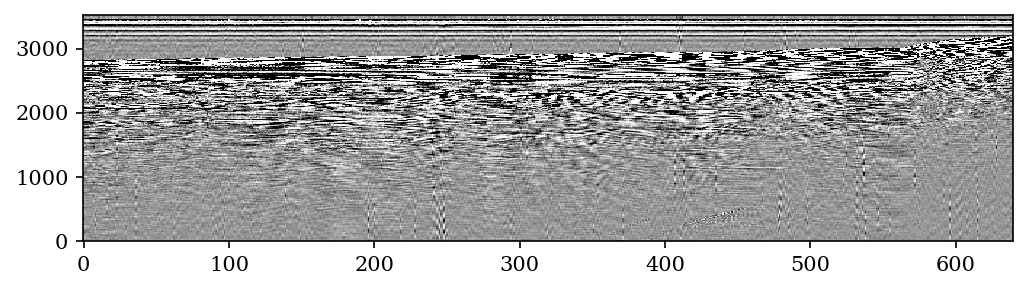

In [32]:
# Plot zero-offset section
shot_ids = natsorted(th.SHOT_ID.unique())
zero_offset = np.zeros((len(shot_ids), dNT))
print(f'Zero-offset section {zero_offset.shape}')
with segyio.open(filename, ignore_geometry=True) as f:
    for ishot, shot_id in enumerate(shot_ids):
        _shot = th[th.SHOT_ID == shot_id]
        id_min = _shot.TRACE_SEQUENCE_FILE.min()
        zero_offset[ishot, :] = f.trace.raw[id_min:id_min + 1]
vis.plot_shot(zero_offset, pclip=0.01, figsize=(8,2), colorbar=False)

26 43 639
1666.040386638491 13628.145504414133 639


<ipython-input-33-28b262b34d84>:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  vis.plot_model(taper0 - wb_taper.astype(np.float), title='Diff water layer prev vs my')


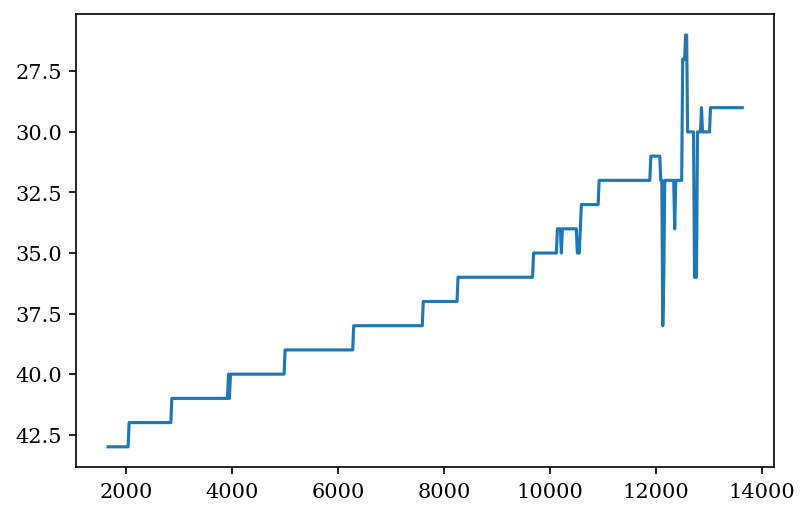

In [33]:
wb = []
xb = []
with segyio.open(filename, ignore_geometry=True) as f:
    for ishot, shot_id in enumerate(range(src_id_min, src_id_max)):
        _shot = th[th.SHOT_ID == shot_id]
        id_min = _shot.TRACE_SEQUENCE_FILE.min()
        s = f.trace.raw[id_min:id_min + 10]
        s = s[:, 450:800]
        amax = np.argmax(np.sum(s, 0))
        wb.append(amax + 450)
        xb.append(_shot['ReceiverX1D'][0:1])
wb_p = [int(np.floor(_wb * 0.002 / 2 * np.min(vp_cgg) / dx)) for _wb in wb]
plt.figure(); plt.plot(xb, wb_p); plt.gca().invert_yaxis()
print(np.min(wb_p), np.max(wb_p), len(wb_p))
print(np.min(xb), np.max(xb), len(xb))

xbb = np.array([_xb.to_list()[0] for _xb in xb])

# for every pixel along OX of velocity model
xv = [i*dx for i in range(nx0 - nexp)]
# find nearest known water depth
wb_taper = np.zeros_like(taper0)
wb_args = []
for ix, x in enumerate(xv):
    arg = np.argmin(np.abs(xbb - x))
    wb_args.append(wb_p[arg]-1)
    wb_taper[-wb_p[arg]-1:, ix] = 1.
plt.figure(); plt.imshow(np.flip(wb_taper, 0));

vis.plot_model(taper0 - wb_taper.astype(np.float), title='Diff water layer prev vs my')

In [34]:
log = vp_cgg[:, 0:1]
print(log.shape)
vmin = np.min(log)
vmax = np.max(log)
vps = []
for wb in wb_args:
    fun = vmin * np.ones_like(log)
    fun[wb:, :] = 450 + fun[wb:, :] + 12 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    vps.append(fun[::-1, :])
vp = np.concatenate(vps, -1)
print(vp.shape)

(152, 1)
(152, 500)


(152, 500)
(152, 500)
Well-log from 10500 maps into ix: 420


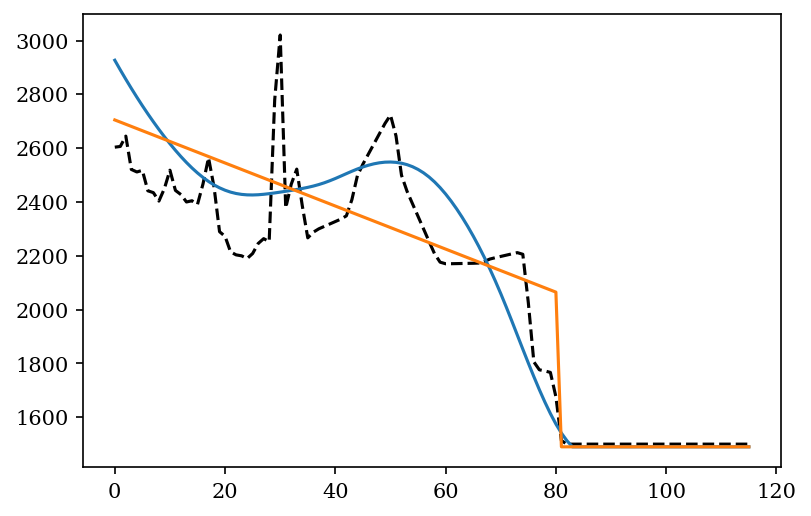

In [35]:
# actual location is 10500 m. The
wlog = lvp[:, 0:1]

vmin = np.min(log)
vmax = np.max(log)
vps = []
print(vp.shape)
for i in range(vp_cgg.shape[-1]):
    wb = wb_taper.shape[0] - np.argmax(wb_taper[:,i])
    fun = vmin * np.ones_like(log)
    fun[wb:, :] = 575 + fun[wb:, :] + 8 * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
    fun = fun[::-1, :]
#     vps.append(np.maximum(fun, log))
    vps.append(fun)
vp = np.concatenate(vps, -1)

print(vp.shape)
print(f'Well-log from {log_loc} maps into ix: {log_idx}')
plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(vp[-len(wlog):, log_idx])

Save /home/ovcharoo/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/logvsinit.png


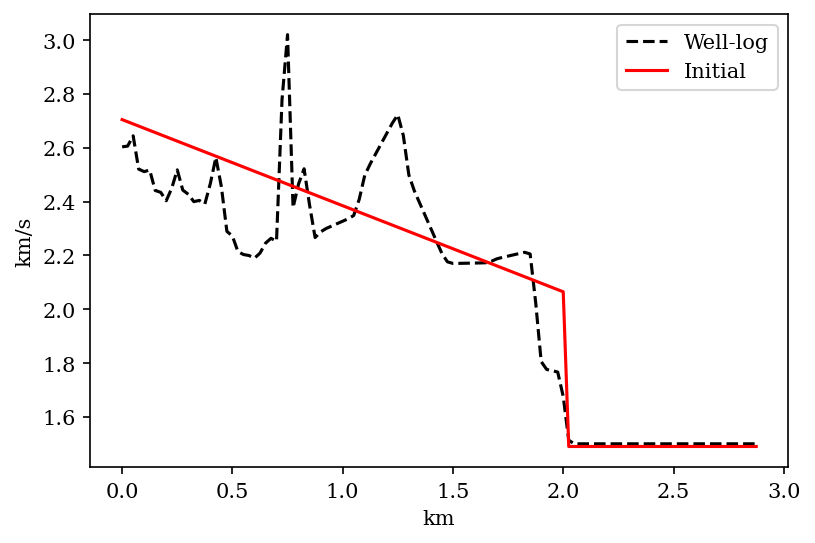

In [36]:
plt.figure(); 
xvec = np.arange(len(wlog)) * dx / 1000
plt.plot(xvec, wlog / 1000, 'k--');
plt.plot(xvec, vp[-len(wlog):, log_idx] / 1000, 'r'); 
plt.legend(['Well-log', 'Initial']); plt.ylabel('km/s'); plt.xlabel('km');
vis.savefig('logvsinit.png')

(152, 600)


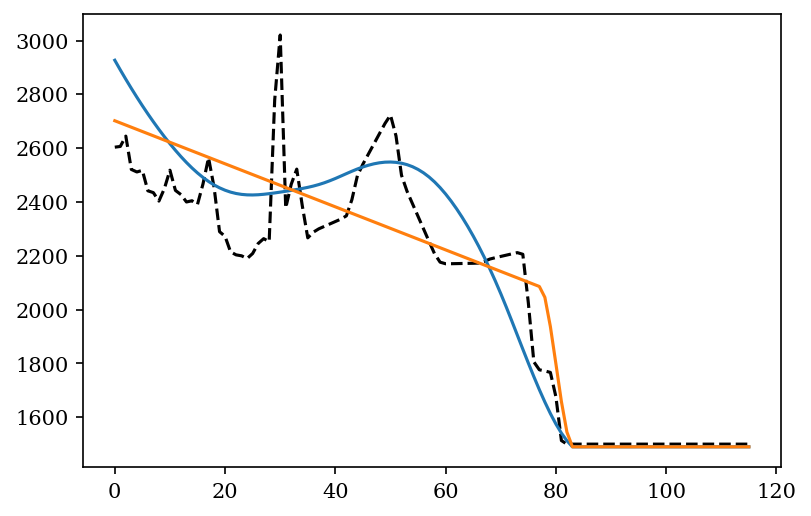

In [37]:
vs = vp.copy() / (3 ** 0.5)
rho = 1e3*0.3 * vp.copy()**0.25

vp = extend(np.where(wb_taper, np.min(vp_cgg), vp), 0, nexp)
vs = extend(np.where(wb_taper, 0, vs), 0, nexp)
rho = extend(np.where(wb_taper, 1000, rho), 0, nexp)

s, w = 2, 5
sigma_truncate = {'sigma': s, 'truncate': (((w - 1)/2)-0.5)/s}
vp = gaussian_filter(vp.copy(), **sigma_truncate)
vs = gaussian_filter(vs.copy(), **sigma_truncate)
rho = gaussian_filter(rho.copy(), **sigma_truncate)

model = api.Model(vp, vs, rho, dx)
print(vp.shape)
vis.plot_model(np.concatenate((vp, vs, rho), 0))

plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):]); plt.plot(vp[-len(wlog):, log_idx])

In [38]:
print(np.min(vp))

1490.0


# Select shots for inversion

In [39]:
# selected_ids = [int(np.floor(x)) for x in np.linspace(src_id_min, src_id_max, 54)]
selected_ids = [int(np.floor(x)) for x in np.linspace(src_id_min, src_id_max, 64)]
ths = th.loc[th['SHOT_ID'].isin(selected_ids)]
print(f'Shots selected {ths.SHOT_ID.nunique()}, {ths.SHOT_ID.unique().min()}..{ths.SHOT_ID.unique().max()}')

Shots selected 64, 80..719


Look at shot 80


Text(0.5, 1.0, 'Streamer')

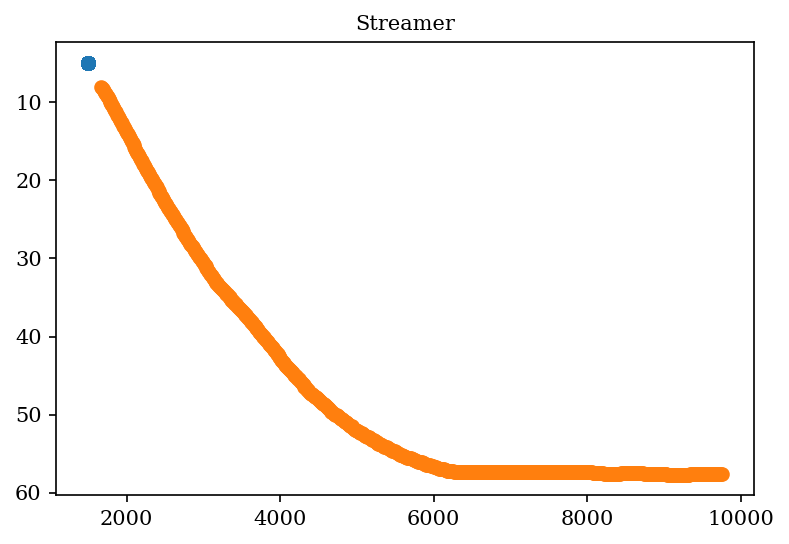

In [40]:
# take 1 shot and visualize streamer
shot_id = selected_ids[0]
print(f'Look at shot {shot_id}')
shot = ths[ths.SHOT_ID == shot_id]

plt.figure(); plt.gca().invert_yaxis();
plt.scatter(shot.SourceX1D, shot.SourceWaterDepth); 
plt.scatter(shot.ReceiverX1D, shot.GroupWaterDepth);
plt.title('Streamer')

Read traces 51840:52488
(648, 3526)
Save /home/ovcharoo/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/raw_shot.png
Save /home/ovcharoo/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/raw_spec.png


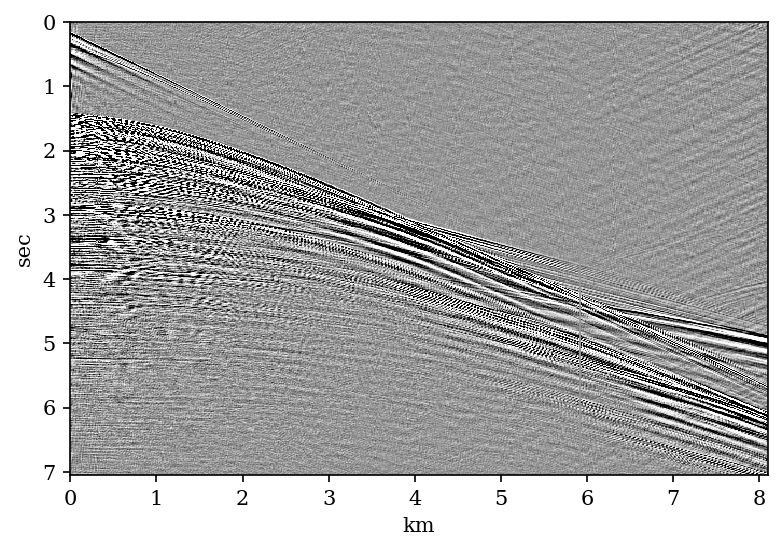

In [41]:
# Read data for this shot
with segyio.open(filename, ignore_geometry=True) as f:
    id_min = shot.TRACE_SEQUENCE_FILE.min()
    id_max = shot.TRACE_SEQUENCE_FILE.max() + 1
    print(f'Read traces {id_min}:{id_max}')
    shot_data = f.trace.raw[id_min:id_max]
print(shot_data.shape)

vis.plot_shot(shot_data, dt=dDT, dx=12.5, pclip=0.01, colorbar=False);
vis.savefig('raw_shot.png')

vis.plot_spectra_dict([{'full': shot_data}], dt=dDT, fmax=100., norm=True)
vis.savefig('raw_spec.png')

# Source wavelet
Thanks Mahesh Kalita and Abdullah Alalai!

In [42]:
wavelets, opts = ld.load_hh(os.path.join(root_field, 'kwlt10p0.hh'))
print(f'Load wavelet for unknown set of shots: {wavelets.shape}.\nParameters: {opts}')

Load wavelet for unknown set of shots: (704, 7052).
Parameters: {'n1': 7052, 'd1': 0.0010000000474974513, 'o1': 0, 'n2': 704, 'd2': 1, 'o2': 0}


In [43]:
vis.plot_shot(wavelets, title='Wavelet for first 704 shots');

In [44]:
def plot_wavelet(x, y, title=''):
    plt.figure(); plt.plot(x, y); 
    plt.xlabel('Time, sec'); plt.title(title);

wavelet = np.mean(wavelets, axis=0, keepdims=True) / 1e4
nt_wavelet = opts['n1']
dt_wavelet = opts['d1']
ax_t = np.arange(0, nt_wavelet)[..., np.newaxis]*dt_wavelet
plot_wavelet(ax_t, wavelet.T, 'Mean source wavelet')

In [45]:
_nt = 1000 # time steps to zoom in
_ws = wavelets[:, 4:_nt] / 1e4
_ax_t = ax_t[4:_nt, :].squeeze()
plt.figure(figsize=(6, 3)); plt.fill_between(_ax_t, np.min(_ws, axis=0), np.max(_ws, axis=0), color='b', alpha=0.8);
plt.plot(_ax_t, np.mean(_ws, axis=0), 'w--', lw=2); 
# plt.title('Wavelet span over a set of offsets'); 
plt.xlabel('Time, sec');
vis.savefig('wavelet.png')

Save /home/ovcharoo/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/wavelet.png


In [46]:
fhi = 10.0
par_bp = {'fhi': fhi, 'btype': 'low', 'order': 4}
par_mut = {'k': 3.5, 'b': -80, 'r': 65}

In [47]:
# !!! NOTE dx/2 added so sources are not on free surface!


rec_ = api.Receivers()

xsrc, ysrc = [], []
selected_wavelets = []
selected_shot_ids = []
data = []
with segyio.open(filename, ignore_geometry=True) as f:
    for shot_id in ths.SHOT_ID.unique():
        clear_output()
        print(shot_id)
        shot = th[th.SHOT_ID == shot_id]

        id_min = shot.TRACE_SEQUENCE_FILE.min()
        id_max = shot.TRACE_SEQUENCE_FILE.max() + 1
        print(f'Read traces {id_min}:{id_max}')
        _shot_data = f.trace.raw[id_min:id_max]
        data.append(np.expand_dims(_shot_data, 0))

        # sources
        xsrc.append(shot.SourceX1D.unique()[0])
        ysrc.append(shot.SourceWaterDepth.unique()[0] + ndeeper * dx)

        # receivers
        xrec = np.round(shot.ReceiverX1D.to_numpy(), 1)
        yrec = np.round(shot.GroupWaterDepth.to_numpy(), 1) + ndeeper * dx
        rec_.add(xrec, yrec)

        selected_wavelets.append(wavelets[shot_id:shot_id+1, :])
        selected_shot_ids.append(shot_id)

src_ = api.Sources(np.array(xsrc), np.array(ysrc))
print(f'Selected shot ids: {selected_shot_ids[0]}..{selected_shot_ids[-1]}, ({len(selected_shot_ids)} items)')
print(f'Will later save all sources into {len(src_)} file')
print(f'Will later save receivers into {len(rec_)} files')
print(f'Will later save wavelets into {len(selected_wavelets)} files')

data = np.concatenate(data, 0)
print(f'Data cube: {data.shape}')

719
Read traces 465912:466560
Selected shot ids: 80..719, (64 items)
Will later save all sources into 64 file
Will later save receivers into 64 files
Will later save wavelets into 64 files
Data cube: (64, 648, 3526)


## Interpolation for near-offset

In [48]:
print(wavelets.shape)
wavelet = np.mean(wavelets, 0) / 1e4
plt.figure(); plt.plot(list(wavelet)[:1000])

(704, 7052)


In [49]:
wavelet = list(wavelet)
nt0 = len(wavelet)
nt_push = 100
for _ in range(nt_push):
    wavelet.insert(0, 0)
wavelet = np.array(wavelet)
bp = ld.bandpass(wavelet[np.newaxis,...], fs=1./dt_wavelet, **par_bp)
plt.figure(); 
plt.plot(list(wavelet)[:1000], 'k--', lw=2)
plt.plot(list(bp[0,...])[:1000], 'b', lw=2)
plt.xlabel('Time, ms')
bp = bp[:,:nt0]
print(bp.shape)

(1, 7052)


(64, 7052)


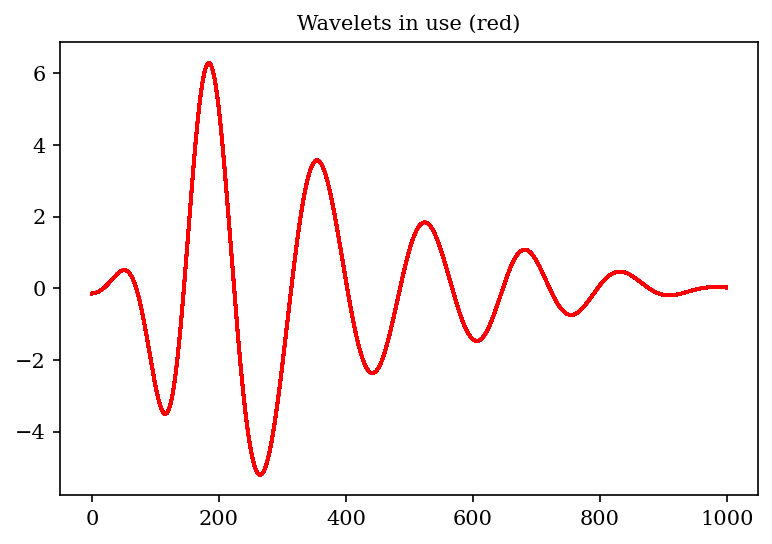

In [50]:
src_wavelets = np.repeat(bp, len(src_), 0)
# src_wavelets = np.repeat(np.mean(wavelets,0, keepdims=True), len(src_), 0)
# src_wavelets = np.repeat(wavelet, len(src_), 0)
# src_wavelets = np.concatenate(selected_wavelets, 0) / 1e4
print(src_wavelets.shape)
bpw = copy.deepcopy(src_wavelets)
# bpw = ld.bandpass(src_wavelets, fs=1./dt_wavelet, **par_bp)

plt.figure(); 
plt.plot(src_wavelets[:,:_nt].T, 'b')
plt.plot(bpw[:, :_nt].T, 'r'); plt.title('Wavelets in use (red)');

# Preprocessing
1. Deconvolve with source wavelet
2. Bandpass < 10 Hz
3. Mute before first break

In [51]:
nsrc, nrec, nt = data.shape
nt_wavelet = src_wavelets.shape[-1]
skip_nt_wavelet = nt_wavelet // nt
skip_rec = 2
limit_nt = 3000
ext_nt = 100
data_p = np.zeros((nsrc, nrec // skip_rec, limit_nt))
data_p_ext = np.zeros((nsrc, nrec // skip_rec, limit_nt + ext_nt))
# for ishot in range(2):
for ishot in range(nsrc):
    clear_output()
    print(f'{ishot+1}/{nsrc}')
    shot = data[ishot, ...].copy()
    print(f'Before prep:\t{data.shape}')
    shot = ld.bandpass(shot, fs=1./dDT, **par_bp)
#     tmp = np.zeros((shot.shape[0], shot.shape[1] + int(nt_push // 2)))
#     tmp[:, int(nt_push // 2):] = shot.copy()
#     shot = ld.bandpass(tmp, fs=1./dDT, **par_bp)
#     shot = ld.mutter(shot, 3.0, -80, 15)
#     shot = ld.mutter(shot, 3.0, -80)
    shot = shot[::skip_rec, :]
    data_p_ext[ishot, ...] = shot[:, :limit_nt + ext_nt]
    data_p[ishot, ...] = shot[:, :limit_nt]
print(f'Data cube:\t{data_p.shape}\nExtended cube:\t{data_p_ext.shape}')

64/64
Before prep:	(64, 648, 3526)
Data cube:	(64, 324, 3000)
Extended cube:	(64, 324, 3100)


In [52]:
# Push field data 50 samples in time to match synthetic wavelet
def pad_nt(dat, npush=0):
    old_shape = list(dat.shape)
    lnt = old_shape[-1]
    old_shape[-1] += int(npush // 2)
    tmp = np.zeros(old_shape)
    tmp[..., int(npush // 2):] = dat
    dat = tmp[..., :lnt]
    print(old_shape, dat.shape)
    return dat

data_p = pad_nt(data_p, nt_push)
data_p_ext = pad_nt(data_p_ext, nt_push)

[64, 324, 3050] (64, 324, 3000)
[64, 324, 3150] (64, 324, 3100)


In [53]:
# rec = copy.deepcopy(rec_)
# for isrc in range(nsrc):
#     rec[isrc].x = rec[isrc].x[::skip_rec]
#     rec[isrc].y = rec[isrc].y[::skip_rec]
# rec = api.Receivers(rec_[0].x[::skip_rec], 75 * np.ones_like(rec_[0].y[::skip_rec]))
# print(f'{len(rec)} streamers with {len(rec[0])} hydrophones in each')
# print(rec)


dsrc = np.round(np.mean(src_.x[1:] - src_.x[:-1]) / dx) * dx
print(f'dsrc:\t{dsrc} m')
src_x0 = np.round(src_.x[0] / dx) * dx
src_x1 = np.round(src_.x[-1] / dx) * dx
print(f'src_x0:\t{src_x0} m\nsrc_x1:\t{src_x1} m')

src_depth = np.round(np.mean(src_.y) / dx) * dx
src = api.Sources(src_x0 + np.arange(nsrc) * dsrc, src_depth * np.squeeze(np.ones((nsrc, 1))))
print(src)

drec = np.round(np.mean(rec_[0].x[1:] - rec_[0].x[:-1]) / dx) * dx
print(f'drec:\t{drec} m')
rec_x0 = np.floor(rec_[0].x[0] / dx) * dx
rec_depth = np.round(np.mean(rec_[0].y) / dx) * dx
rec = api.Receivers(rec_x0 + np.arange(int(nrec / skip_rec)) * drec, rec_depth * np.ones_like(rec_[0].y[::skip_rec]))
print(rec)

dsrc:	200.0 m
src_x0:	1500.0 m
src_x1:	13475.0 m
name:	
x	(64,):	min: 1500.0	max: 14100.0
y	(64,):	min: 50.0	max: 50.0
wavelets:	None
z	(64,):	min: 0.0	max: 0.0
nshot:	64
td	(64,):	min: 0.0	max: 0.0
fc	(64,):	min: 8.0	max: 8.0
amp	(64,):	min: 1.0	max: 1.0
angle	(64,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(64,):	min: 1.0	max: 1.0
drec:	25.0 m
x	(324,):	min: 1650.0	max: 9725.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1650.0	max: 9725.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [54]:
# importlib.reload(vis)
# vis.plot_shot(np.mean(data_p, 0), pclip=0.05, title=f'Mean of {nsrc} processed shots');
# vis.plot_shot(np.std(data_p, 0), pclip=0.05, title=f'STD of {nsrc} processed shots', vmin=0);

# Init Denise API

In [55]:
importlib.reload(api)
denise_root = '../den/'
d = api.Denise(denise_root, verbose=1)

Init Python 3 API for Denise-Black-Edition.
Check binary in ../den/bin/denise
Parse ../den/par/DENISE_marm_OBC.inp
Current directory is /home/ovcharoo/work/nb12_pearson
Init paths at ./outputs/


In [56]:
# d.parser_report()

## Work directory
Where to output everything

In [57]:
d.save_folder = root_fwi
d.set_paths()

Current directory is /home/ovcharoo/work/nb12_pearson
Init paths at ./out_ac/


## Acquisition design

vp:	(152, 600), 1490.0000, 3011.5660 m/s

vs:	(152, 600), 0.0000, 1738.7284 m/s

rho:	(152, 600), 1000.0000, 2222.3845 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 14975.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


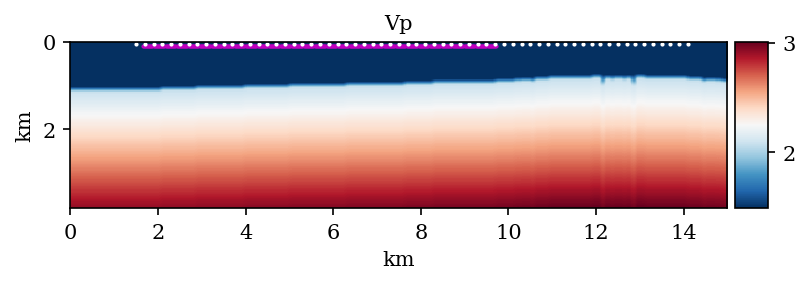

In [58]:
# Set custom wavelet
wls = bpw[:, ::2]
src.wavelets = wls[:, :limit_nt]

vis.plot_acquisition(vp, dx, src, rec, title='Vp')
print(model)

In [59]:
log_dict = {'data': wlog, 'loc': log_loc}
vis.plot_acquisition(vp[:, :500], dx, src, rec, log=log_dict)
vis.savefig('vinit.png')

Save /home/ovcharoo/Dropbox/WORK_HARD/low_elastic/tex/GEOPHYSICS_21/pic/vinit.png


In [60]:
print(src, end='\n\n------------\n')
print(rec)

name:	
x	(64,):	min: 1500.0	max: 14100.0
y	(64,):	min: 50.0	max: 50.0
wavelets	(64, 3000):	min: -5.2003522040678645	max: 6.286853676317875
z	(64,):	min: 0.0	max: 0.0
nshot:	64
td	(64,):	min: 0.0	max: 0.0
fc	(64,):	min: 8.0	max: 8.0
amp	(64,):	min: 1.0	max: 1.0
angle	(64,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(64,):	min: 1.0	max: 1.0

------------
x	(324,):	min: 1650.0	max: 9725.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1650.0	max: 9725.0
y	(324,):	min: 100.0	max: 100.0
name:	]


## Generate true waveforms

Set some runtime parameters which are different from defaults. Check defaults by runnning `help()`

In [61]:
# Elastic modeling
d.verbose = 1
d.PHYSICS = 1
d.SEISMO = 2
d.DT = dDT
d.NT = data_p.shape[-1]
d.TIME = dDT * d.NT
#
d.FC_SPIKE_2 = 10
d.REC_INCR_X = dsrc
d.N_STREAMER = len(rec)

# d.TESTSHOT_START = np.round(0.1 * len(src))
# d.TESTSHOT_END = np.round(0.9 * len(src))
# d.TESTSHOT_INCR = 5

d.TESTSHOT_START = 1
d.TESTSHOT_END = len(src)
d.TESTSHOT_INCR = 10

d.QUELLTYPB = 4
d.QUELLART = 3  

# Acoustic case 
# d.PHYSICS = 2
# src.wavelets = -wls[:, :limit_nt]

print(d.DT, d.NT)

0.002 3000


### Run forward modeling

In [62]:
d.NPROCX = 4
d.NPROCY = 1
# d.forward(model, src, rec, 'mpirun -np 56', disable=False)
# d.forward(model, src, rec, 'mpirun -np 40', disable=True)

In [63]:
d.verbose = 0    # don't show redundant print outs

if d.DT is None:
    d.DT = 0.002
shots = d.get_shots(keys=['_p'])
# shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]

par_shot = {'vmin': -0.05, 'vmax': 0.05}
if shots:
    print(f'Read {len(shots)} shots {shots[0].shape} into list')
    for i in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 3)]:
        try:
            shot_s = divmax(shots[i])
            shot_f = divmax(data_p[i, :, ::d.NDT])
            vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), dt=d.DT, **par_shot)
#             vis.savefig(f'shot_syn_field_{i}.png')
        except:
            print(f'Failed to fetch data for i={i}')

FileNotFoundError: [Errno 2] No such file or directory: './out_ac/su'

# Compare syn and field

In [64]:
if shots:
    no, nt = 50, 500
    ss = shot_s[:no, :nt].copy()
    sf = shot_f[:no, :nt].copy()
    importlib.reload(vis)
    vis.plot_wiggles([sf, ss], n=2, colors=['r', 'b'], legend=['Field', 'Syn'])

NameError: name 'shots' is not defined

In [65]:
if shots:
    tvec = np.arange(nt) * d.DT
    plt.figure(figsize=(6,3)); 
    trace_idx = 0
    plt.plot(tvec, sf[trace_idx,:], 'r', lw=2, label='Field')
    plt.plot(tvec, ss[trace_idx,:], 'b', lw=2, label='Syn')
    # plt.plot(tvec, _dplotted[0][0], 'r', lw=2, label='Field')
    # plt.plot(tvec, _dplotted[1][0], 'b', lw=2, label='Syn')
    plt.legend()
    plt.xlabel('Time, sec')
    vis.savefig('wavelet_syn_field.png')

NameError: name 'shots' is not defined

In [66]:
_, fnames = d.get_shots(keys=['_p'], return_filenames=True)
fnames = natsorted([f for f in fnames if '.it' not in f])
print(f'Found {len(fnames)}, {fnames[0]}..{fnames[-1]}')

assert len(fnames) == data_p.shape[0], 'Check number of shots match!'

for i, f in enumerate(fnames):
    clear_output()
    with segyio.su.open(f, "r+", endian='little', ignore_geometry=True) as dst:
        tmp = data_p[i, :, ::d.NDT]
        dst.trace = tmp
        print(f, dst.tracecount, tmp.shape)

FileNotFoundError: [Errno 2] No such file or directory: './out_ac/su'

## Full-waveform inversion
Invert for elastic properties `vp`, `vs` and `rho`, given `x` and `y` velocity components of wavefield 

## Initial velocity model
Smooth background model with true water bottom and shallow sediments

vp:	(152, 600), 1490.0000, 3011.5660 m/s

vs:	(152, 600), 0.0000, 1738.7284 m/s

rho:	(152, 600), 1000.0000, 2222.3845 m/s

dx:	25.0000
Size:
	OX:	min 0.0000	max 14975.0000 m
Size:
	OZ:	min 0.0000	max 3775.0000 m


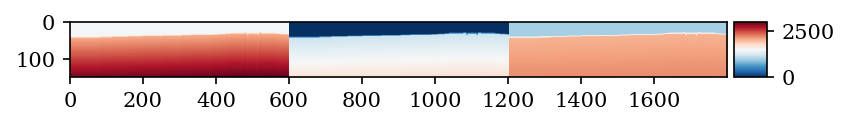

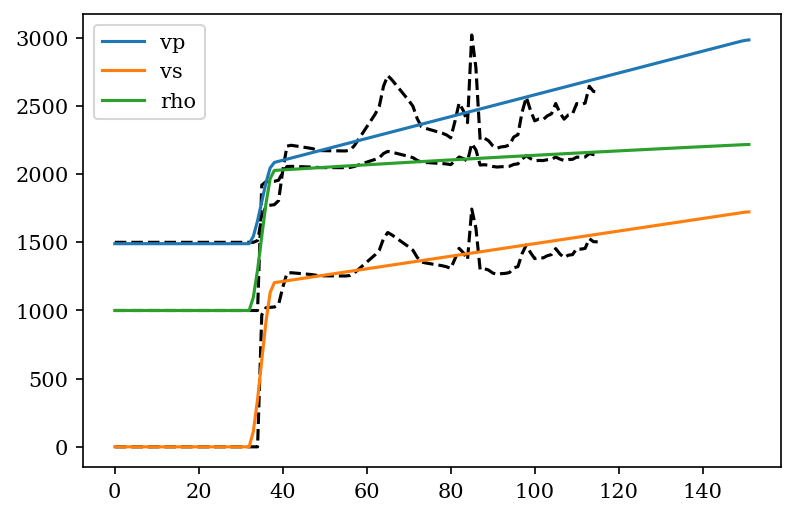

In [67]:
# model_init = api.Model(vp, vs, rho, dx)
model_init = copy.deepcopy(model)
print(model_init)

# log_idx = int(model_init.nx / 2)
ax = plot_model(np.concatenate((model_init.vp, model_init.vs, model_init.rho), 1))
plot_logs(model_log, model_init, log_idx)

## Stages of inversion
Use default parameters, except high- and low-pass corner frequencies of Butterworth filter

In [68]:
d.fwi_stages = []
# for i, freq in enumerate([7]):
#     d.add_fwi_stage(fc_low=4, fc_high=freq)
#     print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')
for i, freq in enumerate([3, 5, 7]):
    d.add_fwi_stage(fc_high=freq, lnorm=2)
    print(f'Stage {i+1}:\n\t{d.fwi_stages[i]}\n')

Stage 1:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 3, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 0, 'WD_DAMP': 0.5, 'WD_DAMP1': 0.5, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 0, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 2:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 5, 'ORDER': 6, 'TIME_WIN': 0, 'GAMMA': 20, 'TWIN-': 0.0, 'TWIN+': 0.0, 'INV_VP_ITER': 0, 'INV_VS_ITER': 0, 'INV_RHO_ITER': 0, 'INV_QS_ITER': 0, 'SPATFILTER': 0, 'WD_DAMP': 0.5, 'WD_DAMP1': 0.5, 'EPRECOND': 3, 'LNORM': 2, 'ROWI': 0, 'STF_INV': 0, 'OFFSETC_STF': -4.0, 'EPS_STF': 0.1, 'NORMALIZE': 0, 'OFFSET_MUTE': 0, 'OFFSETC': 10, 'SCALERHO': 0.5, 'SCALEQS': 1.0, 'ENV': 1, 'N_ORDER': 0}

Stage 3:
	{'PRO': 0.01, 'TIME_FILT': 1, 'FC_LOW': 0.0, 'FC_HIGH': 7, 'ORDER': 6, 'TIME_W

Save (600, 152) as binary to /home/ovcharoo/work/nb12_pearson/taper.bin
Save (600, 152) as binary to /home/ovcharoo/work/nb12_pearson/taper_u.bin
Save (600, 152) as binary to /home/ovcharoo/work/nb12_pearson/taper_rho.bin


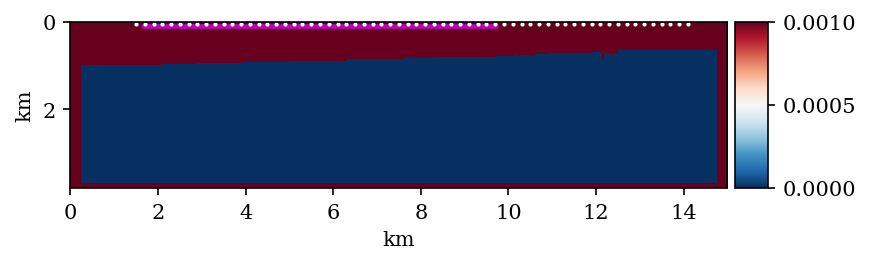

In [69]:
# import loaders as ld
# # Gradient tapering
# d.SWS_TAPER_GRAD_VERT = 0
# d.SWS_TAPER_GRAD_HOR = 0
# d.SWS_TAPER_CIRCULAR_PER_SHOT = 0   # enable grad tapering around sources

d.VPUPPERLIM = 4000.
d.VPLOWERLIM = np.min(model_init.vp)
d.VSUPPERLIM = 3000.
d.VSLOWERLIM = np.min(model_init.vs)
d.RHOUPPERLIM = 3000.
d.RHOLOWERLIM = np.min(model_init.rho)

d.SWS_TAPER_FILE = 1

# mask_water = model_init.vp < 1.01 * np.min(model_init.vp)
# print(mask_water.shape)
# taper = mask_water.copy()
taper = np.zeros_like(model_init.vp)
shift = 4
taper[shift:, :500] = wb_taper[:-shift,:] # water mask
taper[:, 650:] = 1.
taper[:,-10:] = 1. # right
taper[:,:10] = 1. # left
taper[:5,:] = 1. # bottom
nwater= 30 - shift
taper[-nwater:, :] = 1.

# plt.imshow(taper)
if d.SWS_TAPER_FILE:
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d.cwd, 'taper.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d.cwd, 'taper_u.bin'))
    ld.write_bin(np.fliplr((1 - taper.astype(np.float32).T)), os.path.join(d.cwd, 'taper_rho.bin'))
    vis.plot_acquisition(taper, dx, src, rec)

## Run inversion

In [70]:
# d.DATA_DIR = os.path.join(d.save_folder, 'su/predicted/seis')
# d.DATA_DIR = os.path.join(d.save_folder, 'su/seis')
print(f'Target data: {d.DATA_DIR}')

Target data: ./out_ac/su/seis


In [71]:
d.NPROCX = 4
d.NPROCY = 1
d.verbose = 1
par_fwi_runtime = {'run_command': 'mpirun -np 56', 'disable': True}
# d.fwi(model_init, src, rec, **par_fwi_runtime)

# Visualize FWI outputs
It will not hurt to make sure that paths and model dims are up to date. This is necessary when you only want to plot pictures, without running modeling or FWI

In [72]:
d.set_paths()
d.set_model(model_init)
print(d.save_folder)

Current directory is /home/ovcharoo/work/nb12_pearson
Init paths at ./out_ac/
Init model:
	152 x 600, dx = 25.0 m
./out_ac/


## Inverted model
The code ouputs inverted models for every elastic property at every FWI stage. Change `vp` to `vs` or `rho` to explore respective outputs

In [73]:
def plot_log_model(mm, dx, nx, nz0, _src):
    v = mm.copy() / 1000
    plt.figure(); ax = plt.gca();
    map_src = _src.x / dx < nx
    plt.scatter(_src.x[map_src]/1000, _src.y[map_src]/1000, 1, color='w'); 
    cmap='RdBu_r'
#     cmap = 'gist_ncar'
    im = ax.imshow(v[:,:nx0], cmap=cmap, extent=[0, nx0 * dx / 1000, 0, nz0 * dx/1000], 
                   origin='upper', vmin=1.45, vmax=3.5); 
    divider = make_axes_locatable(ax); 
    cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax); cbar.set_label('km/s');
    ax.set_xlabel('km'); ax.set_ylabel('km'); ax.set_title(f); ax.invert_yaxis();

    log = model_log.vp[:, log_idx]
    vh = 420*dx * np.ones_like(log) / 1000 
    ax.plot(vh, np.arange(len(log))*dx/1000, 'k--')
    ax.plot(vh + (log[::-1] - min(log)) / 1000, np.arange(len(log))*dx/1000, 'k')
    plt.pause(0.001)

nx0 = 500
# mpl.rcParams['figure.dpi']= 300
d.verbose = 2

models, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
# models = models[0:1] if models else []
# fnames = fnames[0:1] if models else []
for m, f in zip(models, fnames):
    plot_log_model(m, dx, nx0, nz0, src)
mpl.rcParams['figure.dpi']= 100

Parse files from ./out_ac/model which contain ['vp', 'stage']


FileNotFoundError: [Errno 2] No such file or directory: './out_ac/model'

## Well-logs
Plot logs in true model (dashed) and inverted models (solid) for every inversion stage

In [74]:
# Load inverted models from all stages
vvr = {'vp': None, 'vs': None, 'rho': None}
for k in vvr.keys():
    vvr[k], fnames = d.get_fwi_models([k, 'stage'], return_filenames=True)

for i in range(len(vvr['vp'])):
    plot_logs(model_log, api.Model(vvr['vp'][i], vvr['vs'][i], vvr['rho'][i], dx), log_idx)

Parse files from ./out_ac/model which contain ['vp', 'stage']


FileNotFoundError: [Errno 2] No such file or directory: './out_ac/model'

## Gradients

In [75]:
d.verbose = 0
grads, fnames = d.get_fwi_gradients(return_filenames=True)
for g, f in zip(grads, fnames):
    plot_model(g, f)

FileNotFoundError: [Errno 2] No such file or directory: './out_ac/jacobian'

# Compare wavefiedls before/after

In [76]:
vps, fnames = d.get_fwi_models(['vp', 'stage'], return_filenames=True)
vss, fnames = d.get_fwi_models(['vs', 'stage'], return_filenames=True)
rhos, fnames = d.get_fwi_models(['rho', 'stage'], return_filenames=True)

if vps:
    model_last = api.Model(vps[-1], vss[-1], rhos[-1], dx)
    print(f'Found last model at {fnames[-1]}')
else:
    print(f'Not found the inverted model in {d.save_folder}!')

FileNotFoundError: [Errno 2] No such file or directory: './out_ac/model'

In [77]:
# d.save_folder = root_fwi[:-1] + '_check/'
# print(f'{root_fwi[:-1]} --> {d.save_folder}')

In [78]:
# d.help()

In [79]:
# d.NPROCX = 4
# d.NPROCY = 1
# d.forward(model_last, src, rec, 'mpirun -np 48')

In [80]:
# d.verbose = 0    # don't show redundant print outs

# if d.DT is None:
#     d.DT = 0.002
# shots = d.get_shots(keys=['_p'])
# # shots = [ld.bandpass(s, fs=1./(d.DT * d.NDT), **par_bp) for s in d.get_shots(keys=['_p'])]
# print(f'Read {len(shots)} shots {shots[0].shape} into list')

# for ishot in [int(np.floor(x)) for x in np.linspace(0, len(shots)-1, 4)]:
#     shot_s = divmax(shots[ishot])
#     shot_f = divmax(data_p[ishot, :, ::d.NDT])
#     vis.plot_shot(np.concatenate([np.flip(shot_s, 0), shot_f], axis=0), pclip=0.05)
#     print(f'Syn:\t{shot_s.shape}\nField:\t{shot_f.shape}')

# Acoustic training dataset

In [81]:
# Main
root_home = '/data/oleg/raw/syn_1024_ac_vel/'
root_dataset_field = os.path.join(root_out, 'cgg_1024_ac_vel')
root_dataset_syn = os.path.join(root_out, 'syn_1024_ac_vel')
path_save_rand_models = os.path.join(root_home, 'rand_models.npy')
nmodels = 1024


# Test
# root_home = '/data/oleg/raw/test_32_ac_vel/'
# root_dataset_field = os.path.join(root_out, 'test_cgg_32_ac_vel')
# root_dataset_syn = os.path.join(root_out, 'test_syn_32_ac_vel')
# path_save_rand_models = os.path.join(root_home, 'rand_models.npy')
# nmodels = 32

In [82]:
override = False
vp_init = model_init.vp[:, :500]
nz, nx = vp_init.shape

print(vp_init.shape, nz, nx)

box_min = vp.min()
box_max = 4000
nwater2=35

(152, 500) 152 500


In [83]:
# mask = np.zeros_like(vp_init)
# mask[-nwater2:, :] = 1.
# mask = mask.astype(np.bool)
# vis.plot_model(mask)
# vis.plot_model(vp_init)

In [84]:
def make_init(m_like):
    log = m_like[:, 0:1]
    vmin = np.min(log)
    vmax = np.max(log)
    vps = []
#     wb = nwater2 + np.random.randint(-5, 5)
    wb = nwater2 + np.random.randint(-10, 10)
    slope = 8 + np.random.randint(-4, 4)
    for i in range(nx):
        fun = vmin * np.ones_like(log)
        fun[wb:, :] = 575 + fun[wb:, :] + slope * np.expand_dims(np.arange(len(fun[wb:, 0])), 1)
        fun = fun[::-1, :]
        vps.append(fun)
    return np.concatenate(vps, -1)

print(vp_init.shape)
# test_models = []
# for i in range(10):
#     test_models.append(np.expand_dims(make_init(vp_cgg), 0))
# vis.plot_model(np.mean(np.concatenate(test_models, 0), 0))
# print(f'Well-log from {log_loc} maps into ix: {log_idx}')
# plt.figure(); plt.plot(wlog, 'k--'); plt.plot(log[-len(wlog):] * 1000); plt.plot(vp[-len(wlog):, log_idx])
# vis.plot_acquisition(vp_init, dx, log=log_dict)

(152, 500)


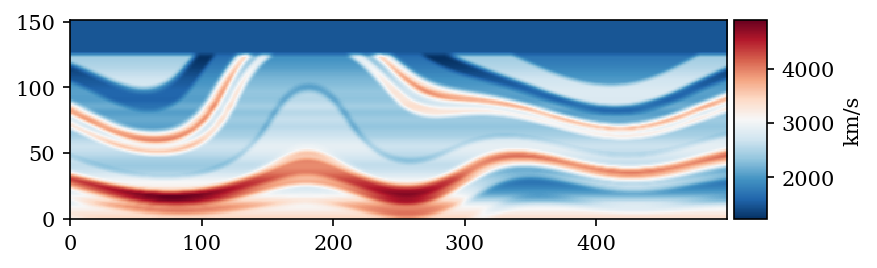

In [85]:
# importlib.reload(vis)
def get_model(nz, nx):
    model = mgen.get_2d_layered_model(nz, nx)
    alpha_x = 1e3 + 1e3 * np.random.rand()
    alpha_z = 2e4 + 1e4 * np.random.rand()
    sigma_x = 20 + 80 * np.random.rand()
    sigma_z = 50 + 30 * np.random.rand()
    model_ = mgen.elastic_transform(model, alpha_x, alpha_z, sigma_x, sigma_z, mode='nearest') 
    geo = mgen.GeologyScaler(model_, [1400, 3000 + 3000 * np.random.rand()])
    model_ = geo.g2r(model_)
    model_ = np.flipud(model_[..., 0])
    model_ -= np.repeat(np.expand_dims(np.mean(model_, -1), 1), nx, axis=-1)
#     model_ += vp_init
    new_init = make_init(vp_init)
    model_ += new_init
    mask = new_init == np.min(new_init)
    model_[mask] = new_init[mask]
#     model_backup = model_.copy()
#     model_[mask] = vp_init[mask]
    s, w = 2, 5
    sigma_truncate = {'sigma': s, 'truncate': (((w - 1)/2)-0.5)/s}
    model_ = gaussian_filter(model_, **sigma_truncate)
    return model_

vis.plot_model(get_model(nz, nx))

In [86]:
def _get_model(imodel, nz, nx):
    model = get_model(nz, nx)
    return model

if not os.path.exists(path_save_rand_models):
    num_cores = multiprocessing.cpu_count() // 2

    print('Start parallel pool for model generation...', end='')
    model_ids = [i for i in range(nmodels)]
    t1 = time.time()
    with multiprocessing.pool.ThreadPool(num_cores) as pool:
        other_models = pool.starmap(_get_model, zip(model_ids, 
                                                   itertools.repeat(nz), 
                                                   itertools.repeat(nx)))
    print(f'OK, {time.time() - t1} sec')
else:
    print(f'Load random models from {path_save_rand_models}...', end='')
    loaded = np.load(path_save_rand_models)
    other_models = [loaded[i, ...] for i in range(loaded.shape[0])]
    print(len(other_models), other_models[0].shape)

Load random models from /data/oleg/raw/syn_1024_ac_vel/rand_models.npy...1024 (152, 500)


In [87]:
par_box = {'vmin': box_min, 'vmax': box_max}
par_box_km = {'vmin': box_min / 1000, 'vmax': box_max / 1000}
print(f'Apply box conditions to {len(other_models)} models of shape {other_models[0].shape}')
for imodel in range(len(other_models)):
    other_models[imodel][other_models[imodel] < box_min] = box_min
    other_models[imodel][other_models[imodel] > box_max] = box_max

Apply box conditions to 1024 models of shape (152, 500)


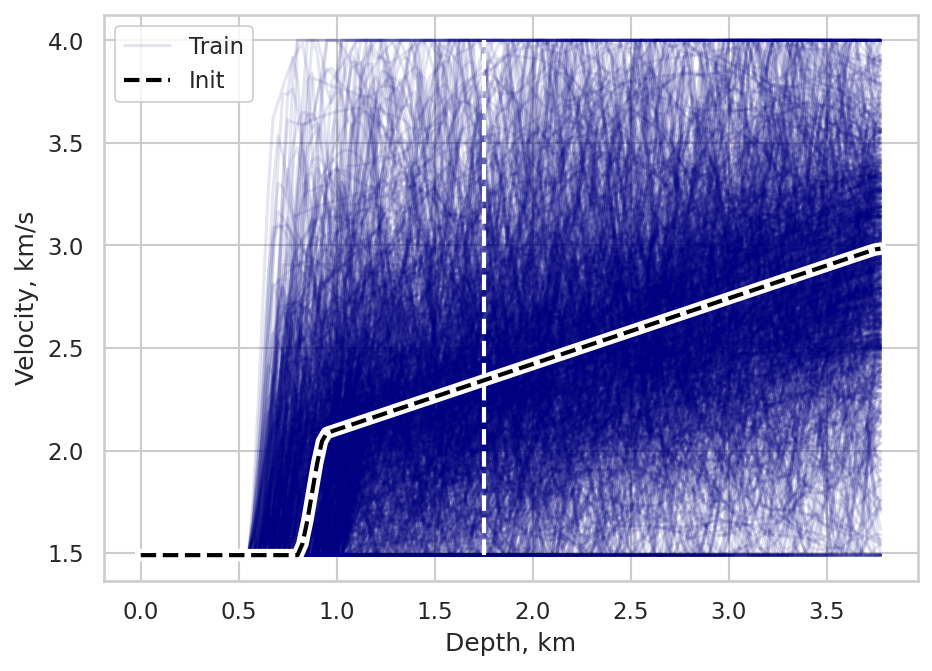

In [92]:
# Lines
# importlib.reload(vis)
log_idx = int(log_dict['loc'] / dx)
true_log = model_init.vp[::-1, log_idx] / 1000
xax = dx * np.arange(len(true_log)) / 1000
for imodel in range(nmodels-1):
    log = other_models[imodel][::-1, log_idx] / 1000
    plt.plot(xax, log, 'navy', alpha=0.1)
log = other_models[nmodels-1][::-1, log_idx] / 1000
plt.plot(xax, log, 'navy', alpha=0.1, label='Train')

# Vertical profile
loc_dist = 1.75
idx_dist = int(loc_dist * 1000 / dx)
plt.plot(np.ones_like(xax) * loc_dist, 
         box_min/1000 + np.linspace(0, 1, len(xax)) * (box_max - box_min)/1000, 
         'w--', lw=2)

# Mean profile
plt.plot(xax, true_log, 'w', lw=6)
plt.plot(xax, true_log, 'k--', lw=2, label='Init')
plt.xlabel('Depth, km'); plt.ylabel('Velocity, km/s'); plt.legend();
# vis.savefig('vlogs.png')

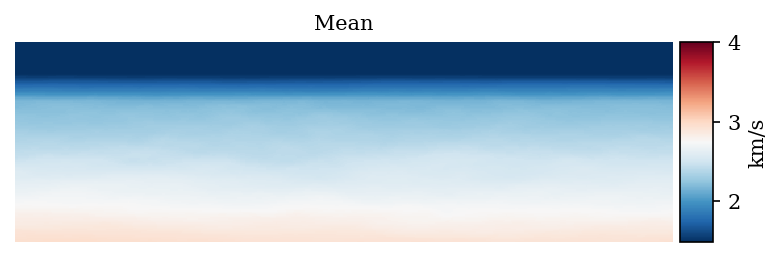

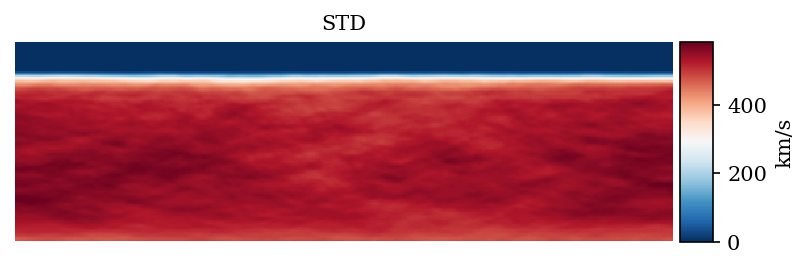

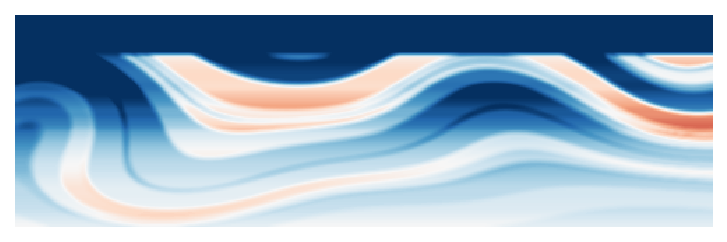

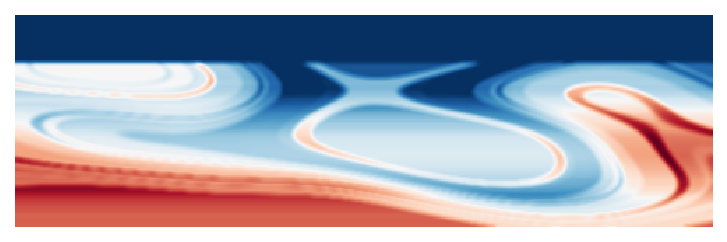

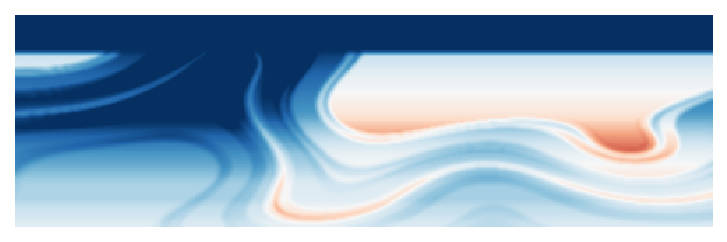

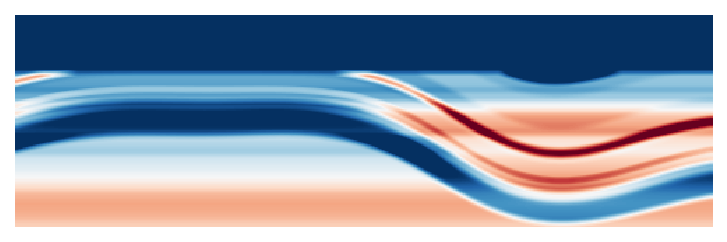

In [89]:
# Images
vis.plot_model(np.mean(other_models, 0) / 1000, title='Mean', axis='off', cax_label='km/s', 
#                colorbar=False,
               **par_box_km)
vis.plot_model(np.std(other_models, 0), title='STD', 
#                colorbar=False,
               axis='off')

for i in [int(np.floor(x)) for x in np.linspace(0, nmodels-1, 4)]:
    vis.plot_model(other_models[i], axis='off', colorbar=False, **par_box
#                    title=f'Model {i+1} / {nmodels}'
                  )

In [90]:
vol = np.concatenate([np.expand_dims(m, 0) for m in other_models], 0)
print(vol.shape)

(1024, 152, 500)


(1024, 152)
(1024,)


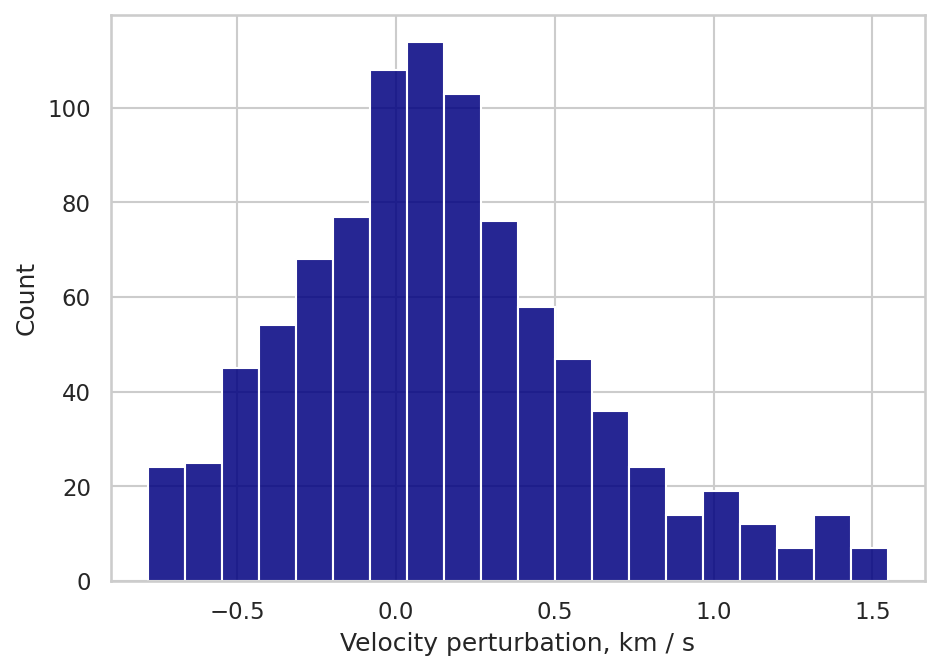

In [91]:
# dist = np.mean((vol - np.mean(vol, keepdims=True))[:, :, log_idx], 1)
the_log = (vol - np.mean(vol, keepdims=True))[:, :, idx_dist] / 1000
print(the_log.shape)
dist = the_log[:, the_log.shape[-1] // 2]
print(dist.shape)

sns.set(style='whitegrid', 
#         palette="deep", 
        palette="Blues_r", 
        rc={"figure.figsize": [7, 5]})


sns.histplot(dist, kde=False, stat='count', 
            color = 'navy',
            alpha = 0.85,
             line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
             binrange=(0.99 * np.min(dist), 0.9 * np.max(dist)),
            ).set(xlabel='Velocity perturbation, km / s', ylabel='Count');

In [247]:
rec_syn = copy.deepcopy(rec)
xsrc0 = src.x[0]
dsrc_syn = 1000.
_nsrc = 3
xsrc = xsrc0 + np.arange(_nsrc) * dsrc_syn
ysrc = np.array([src.y[0] for _ in range(_nsrc)])

src_syn_ac = api.Sources(xsrc, ysrc)
wls = bpw[:len(src_syn_ac), ::2]
src_syn_ac.wavelets = -wls[:, :limit_nt]
print(src_syn_ac)
print(rec_syn)

name:	
x	(3,):	min: 1500.0	max: 3500.0
y	(3,):	min: 50.0	max: 50.0
wavelets	(3, 3000):	min: -6.286853676317875	max: 5.2003522040678645
z	(3,):	min: 0.0	max: 0.0
nshot:	3
td	(3,):	min: 0.0	max: 0.0
fc	(3,):	min: 8.0	max: 8.0
amp	(3,):	min: 1.0	max: 1.0
angle	(3,):	min: 0.0	max: 0.0
QUELLTYPB:	1
src_type	(3,):	min: 1.0	max: 1.0
x	(324,):	min: 1650.0	max: 9725.0
y	(324,):	min: 100.0	max: 100.0
many:	[x	(324,):	min: 1650.0	max: 9725.0
y	(324,):	min: 100.0	max: 100.0
name:	]


In [248]:
# d.NT = 3000

In [249]:
# Init Denise for syn data generation
d_syn = copy.deepcopy(d)
d_syn.verbose = 1
d_syn.NPROCX = 4
d_syn.NPROCY = 1

d_syn.DT = dDT
d_syn.NT = d.NT + ext_nt
d_syn.TIME = dDT * d_syn.NT
d_syn.N_STREAMER = len(rec_syn[0])
d_syn.REC_INCR_X = dsrc_syn

d_syn.PHYSICS = 2

print(d_syn.NT, d_syn.DT)

3100 0.002


/data/oleg/raw/syn_1024_ac_vel/
152 500


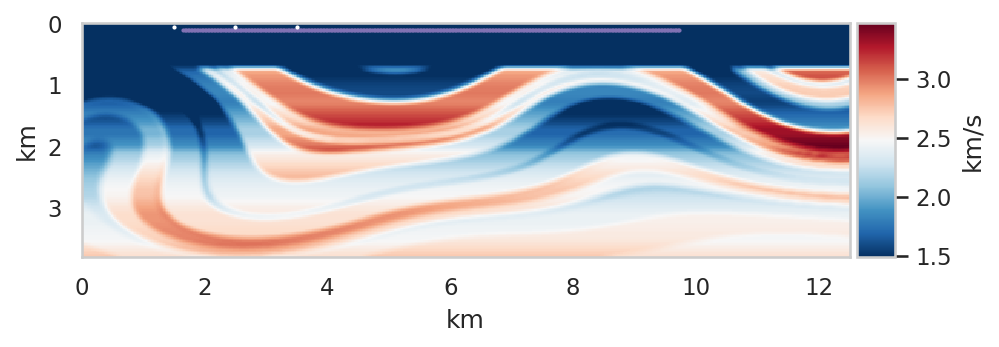

In [299]:
print(root_home)
def make_vp_vs_rho(vp):
    vs = vp.copy() / (3 ** 0.5)
    taper = vp < 1.01 * np.min(vp)
    vs = np.where(taper, 0, vs)
    rho = 1e3*0.3 * vp.copy()**0.25
    rho = np.where(taper, 1000, rho)
    return vp, vs, rho

model_syn = api.Model(*make_vp_vs_rho(other_models[0]), dx)
print(model_syn.nz, model_syn.nx)
mpl.rcParams['axes.grid']= False
vis.plot_acquisition(model_syn.vp, dx, src_syn_ac, rec_syn)
# vis.savefig('rand_acq.png')

# Start modeling acoustic data

In [251]:
def _run_model(im, m, dx, path_output, src_this, run_command):
    _d_syn = copy.deepcopy(d_syn)
    _d_syn.verbose = 0
    d_syn.QUELLART = 3 # custom wavelet
    _d_syn.save_folder = os.path.join(path_output, f'model_{im}/')
    os.makedirs(_d_syn.save_folder, exist_ok=True)
    vp, vs, rho = make_vp_vs_rho(m)
    model_syn = api.Model(vp, vs, rho, dx)
    clear_output()
    _d_syn.forward(model_syn, src_this, rec_syn, run_command)
    return None

if not os.path.exists(path_save_rand_models):
    num_simultaneous_runs = 12
    print('Start parallel pool for modeling...', end='')
    model_ids = [i for i in range(nmodels)]
    t1 = time.time()
    with multiprocessing.pool.ThreadPool(num_simultaneous_runs) as pool:
        tmp = pool.starmap(_run_model, zip(model_ids, other_models, 
                                           itertools.repeat(dx), 
                                           itertools.repeat(root_home),
                                           itertools.repeat(src_syn_ac),
                                           itertools.repeat('mpirun -np 4')))
        print(f'OK, {time.time() - t1} sec')

### Save random models

In [252]:
if not os.path.exists(path_save_rand_models):
    os.makedirs(root_home, exist_ok=True)
    print(f'Save random models to {path_save_rand_models}')
    np.save(path_save_rand_models, np.concatenate([np.expand_dims(m, 0) for m in other_models], 0))

In [253]:
_path_syn_dataset = os.path.join(root_dataset_syn, 'train/raw/')
os.makedirs(_path_syn_dataset, exist_ok=True)
print(_path_syn_dataset)

/data/oleg/data/syn_1024_ac_vel/train/raw/


In [254]:
_path_field_dataset = os.path.join(root_dataset_field, 'train/raw/')
os.makedirs(_path_field_dataset, exist_ok=True)
print(_path_field_dataset)

/data/oleg/data/cgg_1024_ac_vel/train/raw/


In [255]:
# importlib.reload(datasetmaker)

override = False

par_split = {}
par_split['format'] = '.hh'
par_split['dir_dataset'] = root_dataset_syn
par_split['dir_syn'] = root_home
par_split['partitions'] = [90, 5, 5]
par_split['split_from_files'] = False
par_split['split_hh'] = False
par_split['file_keys'] = ['.su']
par_split['from_files'] = False
par_split['jump_files'] = 1
par_split['rules'] = {'raw': 'sfbandpass fhi=15 | sfwindow j1=1'}
par_split['jump_folders'] = 1
par_split['delete_old'] = False
par_split['pre'] = 'sfsuread endian=n su=y |'
par_split['post'] = ' '


if ld.is_empty(_path_syn_dataset) or override:
    maker = datasetmaker.DatasetMaker(par_split, verbose=1)
    maker.run()
    print(f'Check syn dataset in {_path_syn_dataset}')

In [256]:
path_save_field = os.path.join(root_dataset_field, 'data_cgg_ext.npy')
if not os.path.exists(path_save_field):
    os.makedirs(root_dataset_field, exist_ok=True)
    print(f'Save {data_p_ext.shape} to {path_save_field}')
    np.save(path_save_field, data_p_ext)
    
path_save_rand_models = os.path.join(root_dataset_syn, 'rand_models.npy')
if not os.path.exists(path_save_rand_models):
    os.makedirs(root_home, exist_ok=True)
    print(f'Save random models to {path_save_rand_models}')
    np.save(path_save_rand_models, np.concatenate([np.expand_dims(m, 0) for m in other_models], 0))

In [257]:
par_loader={'crop': (None, None), 'skip': (1,1), 'norm': True}
cube_dst = np.load(path_save_field)
loader_dst_tr = ld.CubeLoader(cube_dst, par_loader)

print(_path_syn_dataset)
fnames_ac = ld.parse_files(_path_syn_dataset, '*.hh')
loader_src_tr_ac = ld.Loader(fnames_ac, par_loader)

jloader_tr = ld.JointLoader(loader_src_tr_ac, loader_dst_tr)

/data/oleg/data/syn_1024_ac_vel/train/raw/
Found 2765 files in /data/oleg/data/syn_1024_ac_vel/train/raw/:
	/data/oleg/data/syn_1024_ac_vel/train/raw/model_0_seis_p.shot2.hh
	/data/oleg/data/syn_1024_ac_vel/train/raw/model_1023_seis_p.shot3.hh


In [258]:
index = 2
print(f'Init loader for:\n\tsyn:\t{_path_syn_dataset}\n\tfield:\t{_path_field_dataset}\n')
dat = jloader_tr.__getitem__(index)
print(len(dat), dat[0].shape, dat[2].shape)

Init loader for:
	syn:	/data/oleg/data/syn_1024_ac_vel/train/raw/
	field:	/data/oleg/data/cgg_1024_ac_vel/train/raw/

4 (324, 3100) (324, 3100)


In [259]:
def valinfo(v):
    return v.shape, v.min(), v.max()
    
dat_src = dat[0]
print(dat[1], valinfo(dat_src))
dat_dst = dat[2]
print(dat[3], valinfo(dat_dst))

/data/oleg/data/syn_1024_ac_vel/train/raw/model_1_seis_p.shot1.hh ((324, 3100), -0.7488092, 1.0)
2 ((324, 3100), -1.0, 0.81601167)


Syn:	(324, 3100)
Field:	(324, 3100)


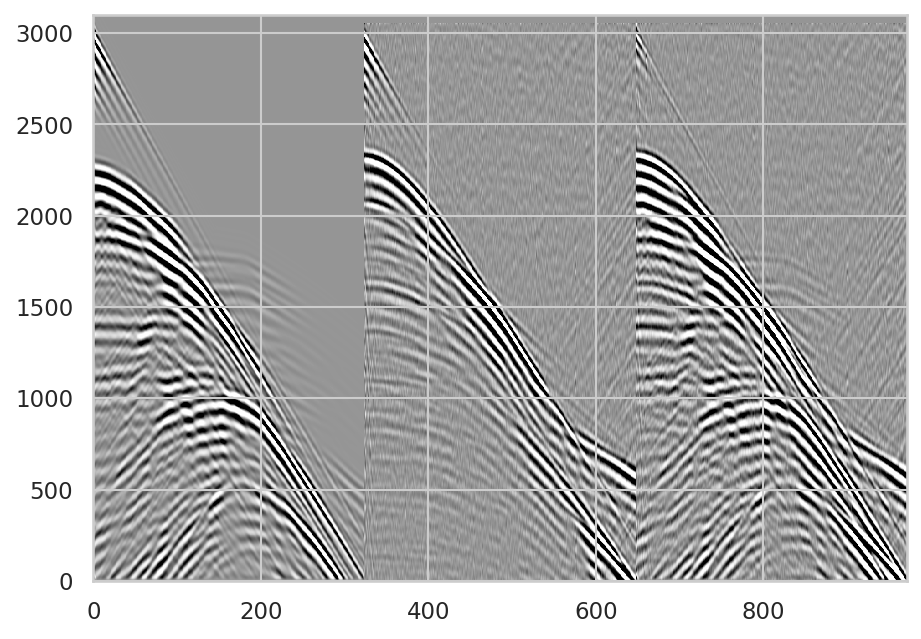

In [260]:
# importlib.reload(ld)
vis.compare_shots(dat_src, dat_dst, 0.1)
print(f'Syn:\t{dat_src.shape}\nField:\t{dat_dst.shape}')

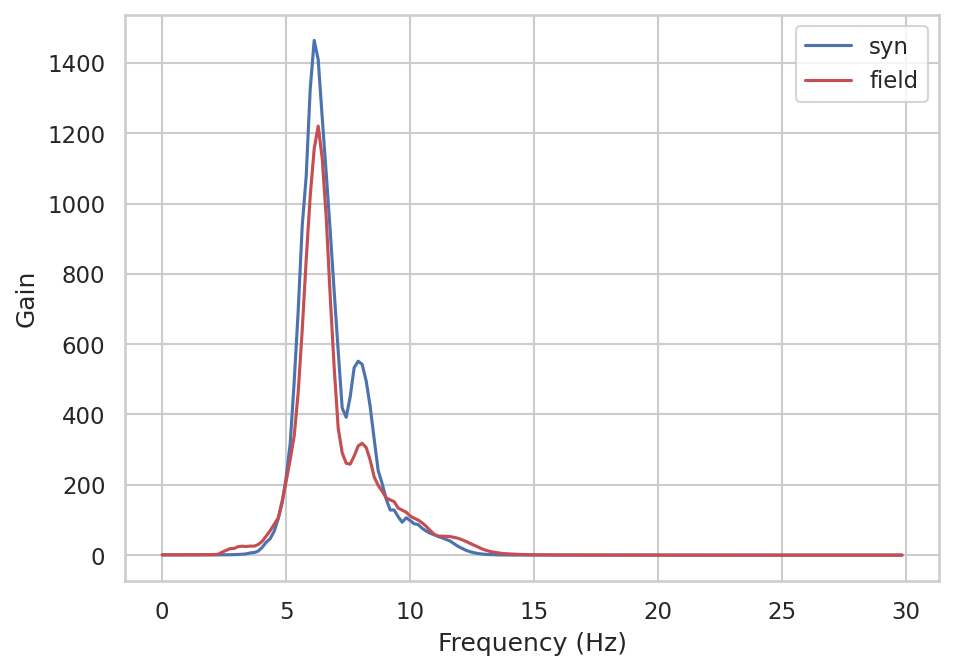

In [261]:
vis.plot_spectra_dict([{'syn': dat_src}, {'field': dat_dst}], d.DT, 30, labels=['', '', ''], norm=False)

In [262]:
# Mean train dataset
def get_loader_stats(loader, dat_shape):
    n_src_tr = len(loader)
    dat_src_tr = np.zeros((n_src_tr, *dat_shape))
    for i in range(n_src_tr):
        print(f'{i+1}/{n_src_tr}', end='\r')
        dat = loader.__getitem__(i)[0]
        if np.isnan(dat).any():
            dat = 0.
            print('NaN caught!')
        dat_src_tr[i,...] = dat
        
    src_tr_mean = np.mean(dat_src_tr, 0)
    src_tr_std = np.std(dat_src_tr, 0)
    return src_tr_mean, src_tr_std

path_src_tr_mean = os.path.join(root_dataset_syn, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn, 'src_tr_std.npy')
path_dst_tr_mean = os.path.join(root_dataset_syn, 'dst_tr_mean.npy')
path_dst_tr_std = os.path.join(root_dataset_syn, 'dst_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean, src_tr_std = get_loader_stats(loader_src_tr_ac, dat_src.shape)
    dst_tr_mean, dst_tr_std = get_loader_stats(loader_dst_tr, dat_dst.shape)
    np.save(path_src_tr_mean, src_tr_mean)
    np.save(path_src_tr_std, src_tr_std)
    np.save(path_dst_tr_mean, dst_tr_mean)
    np.save(path_dst_tr_std, dst_tr_std)
else:
    print(f'Load mean and std from {path_src_tr_mean}')
    src_tr_mean = np.load(path_src_tr_mean)
    src_tr_std = np.load(path_src_tr_std)
    dst_tr_mean = np.load(path_dst_tr_mean)
    dst_tr_std = np.load(path_dst_tr_std)

Load mean and std from /data/oleg/data/syn_1024_ac_vel/src_tr_mean.npy


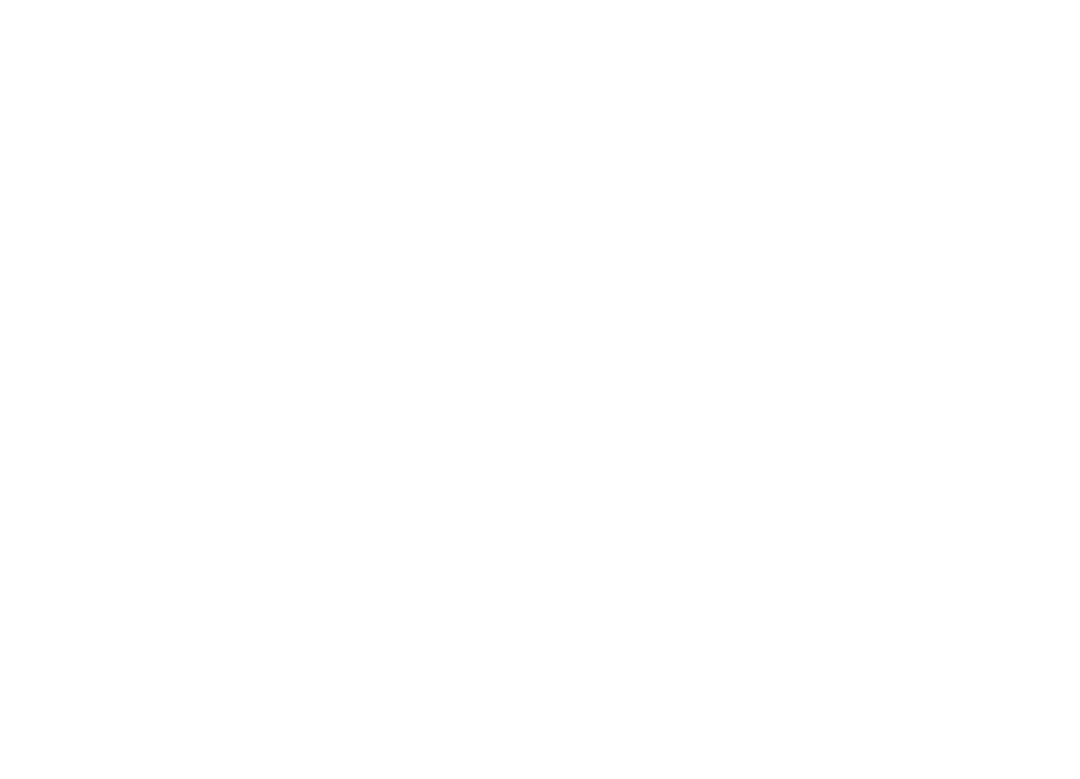

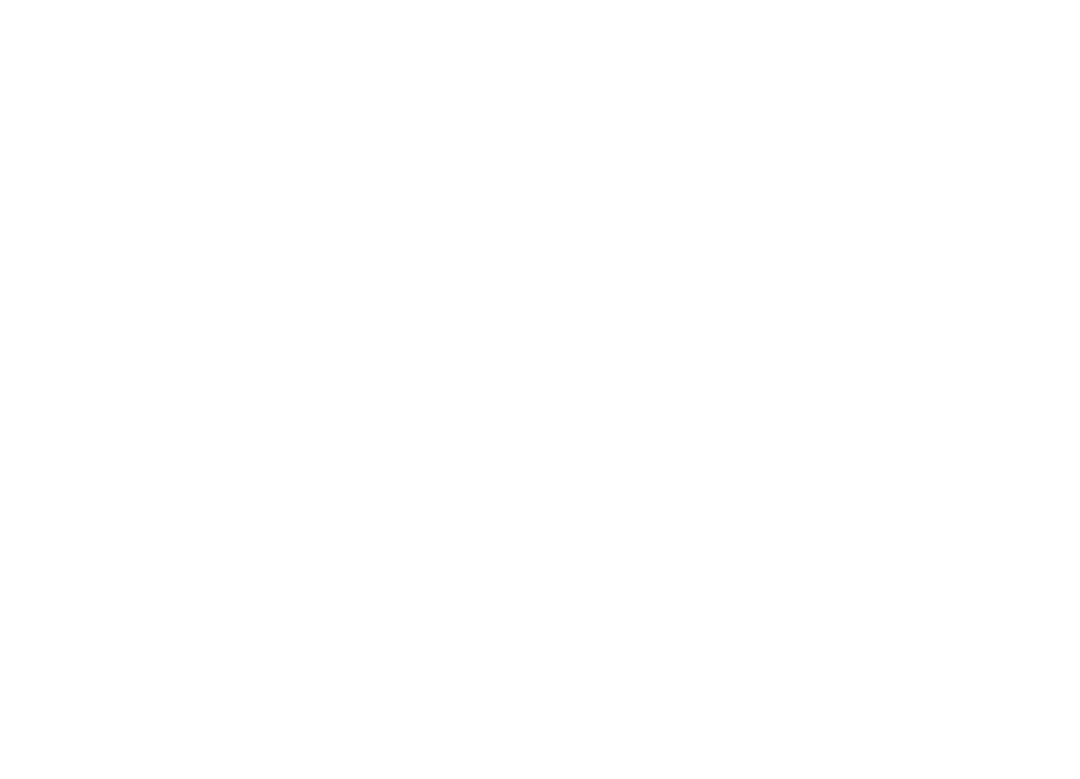

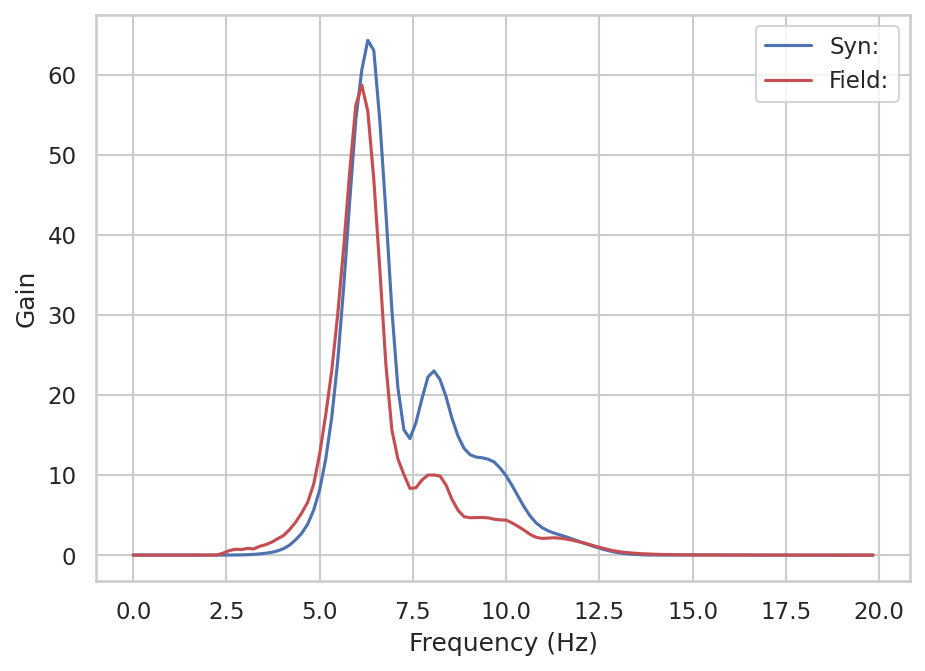

In [263]:
vis.plot_shot(np.concatenate([src_tr_mean, dst_tr_mean], 0), 
              title='Mean synthetic / field', colorbar=True,
              dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_shot(np.concatenate([src_tr_std, dst_tr_std], 0), 
              title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_spectra_dict([{'Syn:': src_tr_mean}, {'Field:': dst_tr_mean}], dt=d.DT, fmax=20)

# Same models but elastic modeling

In [264]:
root_home_el = '/data/oleg/raw/syn_1024_el_vel/'  
root_dataset_field_el = os.path.join(root_out, 'cgg_1024_el_vel')
root_dataset_syn_el = os.path.join(root_out, 'syn_1024_el_vel')

# root_home_el = '/data/oleg/raw/test_syn_32_el_vel/'  
# root_dataset_field_el = os.path.join(root_out, 'test_cgg_32_el_vel')
# root_dataset_syn_el = os.path.join(root_out, 'test_syn_32_el_vel')

Wavelet for elastic modeling is the same as for acoustic but flipped (there mush be a bug in the source C code)

In [265]:
d_syn.SEISMO = 2
d_syn.PHYSICS = 1
d_syn.NPROCX = 2
src_syn_el = copy.deepcopy(src_syn_ac)
src_syn_el.wavelets = wls[:, :limit_nt]

# Start modeling elastic data

In [266]:
if ld.is_empty(root_home_el):
    num_simultaneous_runs = 8
    # NCORES = NRUNS * (NSRC * NPROCX * NPROCY) = 8 * (3 * 2) = 48. Brackets outlune nproc for every run
    print('Start parallel pool for modeling...', end='')
    model_ids = [i for i in range(nmodels)]
    t1 = time.time()
    with multiprocessing.pool.ThreadPool(num_simultaneous_runs) as pool:
        tmp = pool.starmap(_run_model, zip(model_ids, other_models, 
                                           itertools.repeat(dx), 
                                           itertools.repeat(root_home_el),
                                           itertools.repeat(src_syn_el),
                                           itertools.repeat('mpirun -np 6')))
    print(f'OK, {time.time() - t1} sec')

In [267]:
_path_syn_dataset_el = os.path.join(root_dataset_syn_el, 'train/raw/')
os.makedirs(_path_syn_dataset_el, exist_ok=True)
print(_path_syn_dataset_el)

/data/oleg/data/syn_1024_el_vel/train/raw/


In [268]:
par_split_el = copy.deepcopy(par_split)
par_split_el['dir_dataset'] = root_dataset_syn_el
par_split_el['dir_syn'] = root_home_el

if ld.is_empty(_path_syn_dataset_el) or override:
    maker = datasetmaker.DatasetMaker(par_split_el, verbose=1)
    maker.run()
print(f'Check syn dataset in {_path_syn_dataset_el}')

Check syn dataset in /data/oleg/data/syn_1024_el_vel/train/raw/


In [269]:
path_save_field_el = os.path.join(root_dataset_field_el, 'data_cgg_ext.npy')
if not os.path.exists(path_save_field_el):
    os.makedirs(root_dataset_field_el, exist_ok=True)
    print(f'Save {data_p_ext.shape} to {path_save_field_el}')
    np.save(path_save_field_el, data_p_ext)

path_save_rand_models = os.path.join(root_dataset_syn_el, 'rand_models.npy')
if not os.path.exists(path_save_rand_models):
    os.makedirs(root_home, exist_ok=True)
    print(f'Save random models to {path_save_rand_models}')
    np.save(path_save_rand_models, np.concatenate([np.expand_dims(m, 0) for m in other_models], 0))

In [270]:
print(_path_syn_dataset_el)
fnames_el = ld.parse_files(_path_syn_dataset_el, '*.hh', verbose=0)
loader_src_tr_el = ld.Loader(fnames_el, par_loader)

jloader_tr = ld.JointLoader(loader_src_tr_el, loader_dst_tr)

print(f'Init loader for:\n\tsyn:\t{_path_syn_dataset_el}\n\tfield:\t{_path_field_dataset}\n')
dat = jloader_tr.__getitem__(index)
print(len(dat), dat[0].shape, dat[2].shape)

/data/oleg/data/syn_1024_el_vel/train/raw/
Init loader for:
	syn:	/data/oleg/data/syn_1024_el_vel/train/raw/
	field:	/data/oleg/data/cgg_1024_ac_vel/train/raw/

4 (324, 3100) (324, 3100)


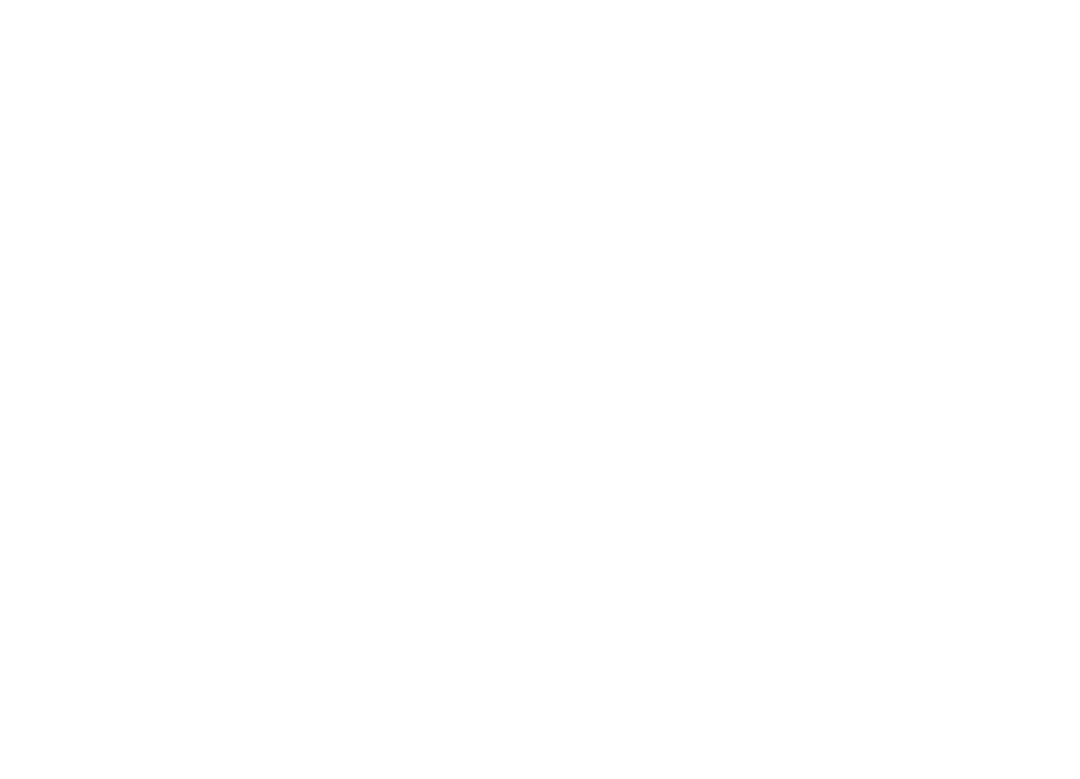

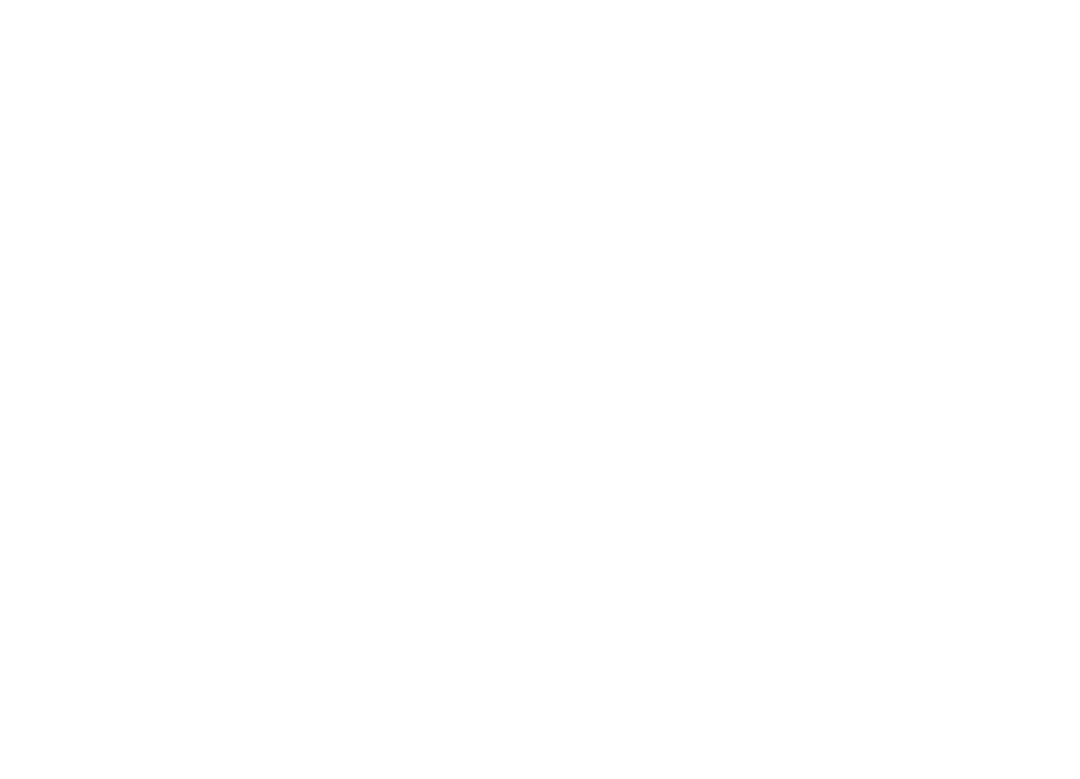

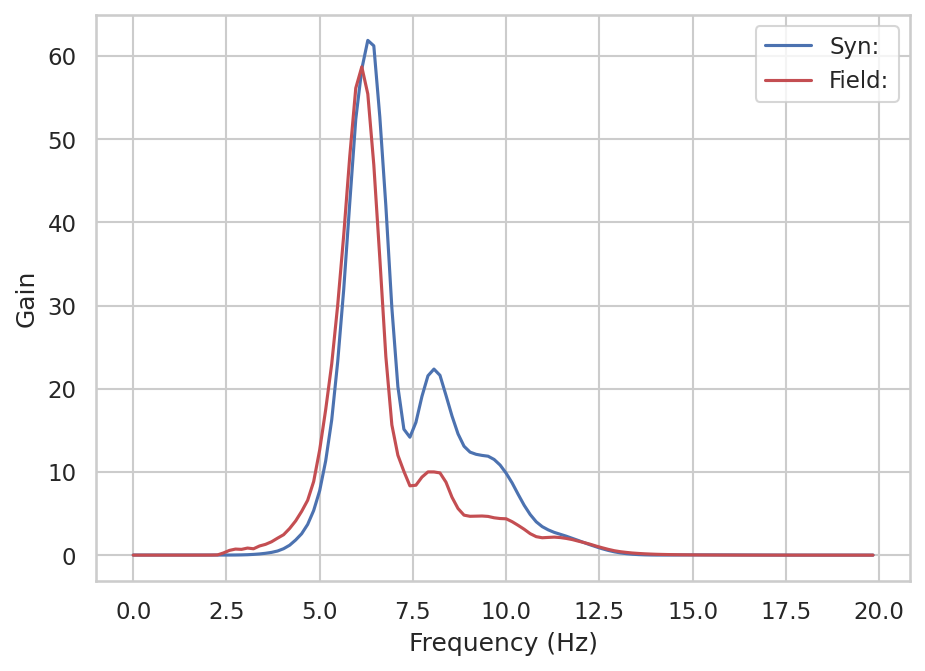

In [271]:
path_src_tr_mean = os.path.join(root_dataset_syn_el, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn_el, 'src_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean, src_tr_std = get_loader_stats(loader_src_tr_el, dat_src.shape)
    np.save(path_src_tr_mean, src_tr_mean)
    np.save(path_src_tr_std, src_tr_std)
else:
    src_tr_mean = np.load(path_src_tr_mean)
    src_tr_std = np.load(path_src_tr_std)

vis.plot_shot(np.concatenate([src_tr_mean, dst_tr_mean], 0), 
              title='Mean synthetic / field', colorbar=True,
              dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_shot(np.concatenate([src_tr_std, dst_tr_std], 0), 
              title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_spectra_dict([{'Syn:': src_tr_mean}, {'Field:': dst_tr_mean}], dt=d.DT, fmax=20)

# Spike elastic data

In [272]:
# root_home_spike = '/home/ovcharoo/spike_1024_el/'  
# root_dataset_syn_spike = os.path.join(root_out, 'spike_1024_el')

In [273]:
# def _run_model_spike(im, m, dx, path_output, src_this, run_command):
#     _d_syn = copy.deepcopy(d_syn)
#     _d_syn.verbose = 0
#     _d_syn.QUELLART = 6 # spike
#     _d_syn.FC_SPIKE_2 = 6
#     _d_syn.save_folder = os.path.join(path_output, f'model_{im}/')
#     os.makedirs(_d_syn.save_folder, exist_ok=True)
#     vp, vs, rho = make_vp_vs_rho(m)
#     model_syn = api.Model(vp, vs, rho, dx)
#     clear_output()
#     _d_syn.forward(model_syn, src_this, rec_syn, run_command)
#     return None

# if ld.is_empty(root_home_spike):
#     num_simultaneous_runs = 8
#     # NCORES = NRUNS * (NSRC * NPROCX * NPROCY) = 8 * (3 * 2) = 48. Brackets outlune nproc for every run
#     print('Start parallel pool for modeling...', end='')
#     model_ids = [i for i in range(nmodels)]
#     t1 = time.time()
#     with multiprocessing.pool.ThreadPool(num_simultaneous_runs) as pool:
#         tmp = pool.starmap(_run_model_spike, zip(model_ids, other_models, 
#                                            itertools.repeat(dx), 
#                                            itertools.repeat(root_home_spike),
#                                            # Use the same source as elastic, but change flag QUELLART on the fly
#                                            itertools.repeat(src_syn_el),
#                                            itertools.repeat('mpirun -np 6')))

In [274]:
# _path_syn_dataset_spike = os.path.join(root_dataset_syn_spike, 'train/raw/')
# os.makedirs(_path_syn_dataset_el, exist_ok=True)
# print(_path_syn_dataset_spike)

In [275]:
# par_split_spike = copy.deepcopy(par_split)
# par_split_spike['dir_dataset'] = root_dataset_syn_spike
# par_split_spike['dir_syn'] = root_home_spike

# if ld.is_empty(_path_syn_dataset_spike) or override:
#     maker = datasetmaker.DatasetMaker(par_split_spike, verbose=1)
#     maker.run()
# print(f'Check syn dataset in {_path_syn_dataset_spike}')

In [276]:
# print(_path_syn_dataset_spike)
# fnames_spike = ld.parse_files(_path_syn_dataset_spike, '*.hh', verbose=0)
# loader_src_tr_spike = ld.Loader(fnames_spike, par_loader)

# jloader_tr = ld.JointLoader(loader_src_tr_spike, loader_dst_tr)

# print(f'Init loader for:\n\tsyn:\t{_path_syn_dataset_el}\n\tfield:\t{_path_field_dataset}\n')
# dat = jloader_tr.__getitem__(index)
# print(len(dat), dat[0].shape, dat[2].shape)

# path_src_tr_mean = os.path.join(root_dataset_syn_spike, 'src_tr_mean.npy')
# path_src_tr_std = os.path.join(root_dataset_syn_spike, 'src_tr_std.npy')
# if not os.path.exists(path_src_tr_mean):
#     src_tr_mean, src_tr_std = get_loader_stats(loader_src_tr_spike, dat_src.shape)
#     np.save(path_src_tr_mean, src_tr_mean)
#     np.save(path_src_tr_std, src_tr_std)
# else:
#     src_tr_mean = np.load(path_src_tr_mean)
#     src_tr_std = np.load(path_src_tr_std)

# vis.plot_shot(np.concatenate([src_tr_mean, dst_tr_mean], 0), 
#               title='Mean synthetic / field', colorbar=True,
#               dt=d.DT, vmin=-0.1, vmax=0.1)
# vis.plot_shot(np.concatenate([src_tr_std, dst_tr_std], 0), 
#               title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
# vis.plot_spectra_dict([{'Syn:': src_tr_mean}, {'Field:': dst_tr_mean}], dt=d.DT, fmax=20)

# Match successful shots from acoustic and elastic
Acoustic modeling is prone to numerical instabilities, for some reason. For fair comparison we have to filter out unsuccessful shots first.

In [277]:
selected_fnames_ac = []
for i in range(len(loader_src_tr_ac)):
    dat_ac, fname_ac = loader_src_tr_ac.__getitem__(i)
    if np.mean(np.abs(dat_ac)) > 1e-3:
        selected_fnames_ac.append(fname_ac)
print(f'Filter out failed acoustic shots: {len(loader_src_tr_ac)} --> {len(selected_fnames_ac)}')

Filter out failed acoustic shots: 2765 --> 2765


In [278]:
print(f'Num acoustic files:\t{len(selected_fnames_ac)}\nNum elastic files:\t{len(fnames_el)}')
subset_ac = set([os.path.split(f)[-1] for f in selected_fnames_ac])
subset_el = set([os.path.split(f)[-1] for f in fnames_el])
print(f'Num unique acoustic files:\t{len(subset_ac)}\nNum unique elastic files:\t{len(subset_el)}')

Num acoustic files:	2765
Num elastic files:	2765
Num unique acoustic files:	2765
Num unique elastic files:	2765


In [279]:
# print('\n'.join(natsorted(subset_ac)))
# print('----------------------------------------')
# print('\n'.join(natsorted(subset_el)))
# print('----------------------------------------')
# common_files = [f for f in subset_ac if f in subset_el]
# rejected_files = [f for f in subset_ac if f not in subset_el]
common_files = list(subset_ac & subset_el)
print(f'Number of commonly successful files: {len(common_files)}')
# print('\n'.join(rejected_files))

sorted_fnames_ac = [os.path.join(os.path.split(selected_fnames_ac[0])[0], f) for f in common_files]
sorted_fnames_el = [os.path.join(os.path.split(fnames_el[0])[0], f) for f in common_files]

Number of commonly successful files: 2765


In [280]:
loader_src_tr_ac = ld.Loader(sorted_fnames_ac, par_loader)
loader_src_tr_el = ld.Loader(sorted_fnames_el, par_loader)

jjloader_tr = ld.JointLoader(loader_src_tr_ac, loader_src_tr_el)

Temporal sampling: 0.002
Model id: 324, shot id: 2
/data/oleg/data/syn_1024_ac_vel/train/raw/model_324_seis_p.shot2.hh ((324, 3100), -0.7314831, 1.0) 0.039782997
/data/oleg/data/syn_1024_el_vel/train/raw/model_324_seis_p.shot2.hh ((324, 3100), -0.7314831, 1.0) 0.02917861


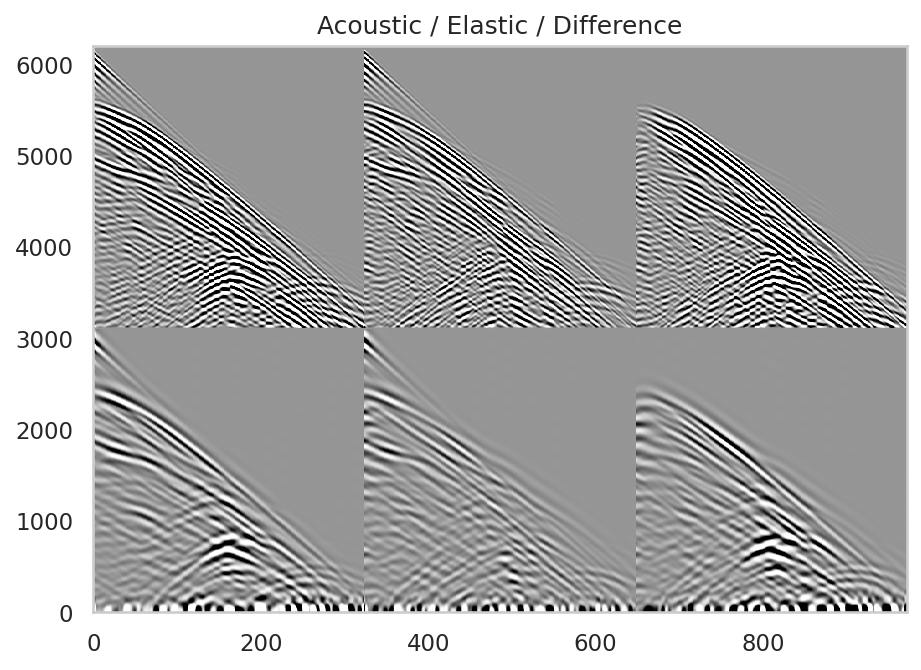

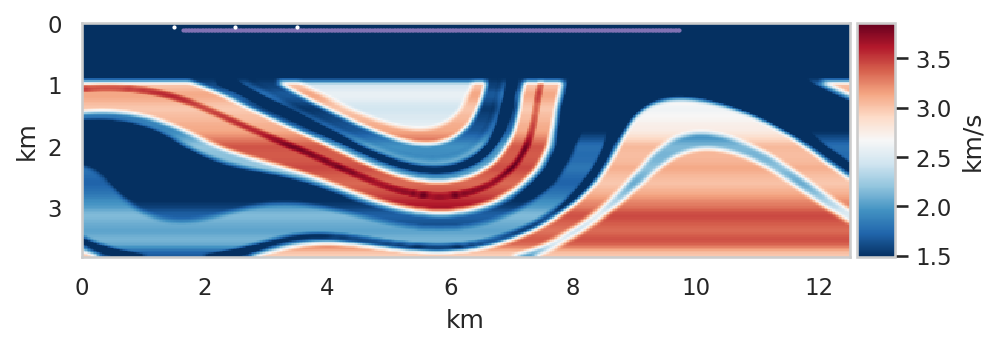

In [316]:
index += 1
dat_el = jjloader_tr.__getitem__(index)

par_bp = {'fs': 1/(d_syn.DT * d_syn.NDT), 'fhi': 3, 'btype': 'low'}
print(f'Temporal sampling: {d_syn.DT * d_syn.NDT}')

dat_src_ac = dat_el[0]
dat_src_el = dat_el[2]

model_id = int((os.path.split(dat_el[1])[-1]).split('_')[1])
shot_id = int((os.path.split(dat_el[1])[-1]).split('.')[-2].replace('shot', ''))
print(f'Model id: {model_id}, shot id: {shot_id}')

print(dat_el[1], valinfo(dat_src_ac), np.mean(np.abs(dat_src_ac)))
print(dat_el[3], valinfo(dat_src_el), np.mean(np.abs(dat_src_el)))

vis.plot_shot(np.concatenate([ld.divmax(np.concatenate([dat_src_ac, dat_src_el, dat_src_el - dat_src_ac], 0)),
                             ld.divmax(np.concatenate([ld.bandpass(dat_src_ac, **par_bp),
                                                       ld.bandpass(dat_src_el, **par_bp),
                                                       ld.bandpass(dat_src_el - dat_src_ac, **par_bp)], 0))], 1),
             pclip=0.1,
             axis='off',
             title='Acoustic / Elastic / Difference')
vis.plot_acquisition(other_models[model_id], dx, src_syn_ac, rec_syn)
# print(f'Syn:\t{dat_src.shape}\nField:\t{dat_src_el.shape}')

# Save compatible datasets as new

In [282]:
root_dataset_syn_ac = copy.copy(root_dataset_syn)
root_dataset_syn_filt_ac = root_dataset_syn_ac.replace('_ac', '_filt_ac')
print(f'Acoustic:\n\t{root_dataset_syn} -->\n\t{root_dataset_syn_filt_ac}')

root_dataset_syn_filt_el = root_dataset_syn_el.replace('_el', '_filt_el')
print(f'Elastic:\n\t{root_dataset_syn_el} -->\n\t{root_dataset_syn_filt_el}')

Acoustic:
	/data/oleg/data/syn_1024_ac_vel -->
	/data/oleg/data/syn_1024_filt_ac_vel
Elastic:
	/data/oleg/data/syn_1024_el_vel -->
	/data/oleg/data/syn_1024_filt_el_vel


# Acoustic

In [283]:
if not os.path.exists(root_dataset_syn_filt_ac):
    cmd = f'cp -r {root_dataset_syn_ac} {root_dataset_syn_filt_ac}'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_ac}/train/raw/*.shot*.hh'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_ac}/cube*.npy'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_ac}/train/raw/*.shot*.hh'
    print(cmd); os.system(cmd);

    commands = []
    for f in sorted_fnames_ac:
        cmd = f'cp {f} {f.replace(root_dataset_syn_ac, root_dataset_syn_filt_ac)}'
        commands.append(cmd)
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

## Elastic

In [284]:
if not os.path.exists(root_dataset_syn_filt_el):
    cmd = f'cp -r {root_dataset_syn_el} {root_dataset_syn_filt_el}'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_el}/train/raw/*.shot*.hh'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_el}/cube*.npy'
    print(cmd); os.system(cmd);

    cmd = f'rm {root_dataset_syn_filt_el}/train/raw/*.shot*.hh'
    print(cmd); os.system(cmd);

    commands = []
    for f in sorted_fnames_el:
        cmd = f'cp {f} {f.replace(root_dataset_syn_el, root_dataset_syn_filt_el)}'
        commands.append(cmd)
        
    with multiprocessing.Pool() as pool:
        pool.map(os.system, commands)

# Init loaders and compare mean and std

In [285]:
path_dst_tr_mean = os.path.join(root_dataset_syn, 'dst_tr_mean.npy')
path_dst_tr_std = os.path.join(root_dataset_syn, 'dst_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    dst_tr_mean, dst_tr_std = get_loader_stats(loader_dst_tr, dat_dst.shape)
    np.save(path_dst_tr_mean, dst_tr_mean)
    np.save(path_dst_tr_std, dst_tr_std)
else:
    print(f'Load mean and std from {path_src_tr_mean}')
    dst_tr_mean = np.load(path_dst_tr_mean)
    dst_tr_std = np.load(path_dst_tr_std)

Load mean and std from /data/oleg/data/syn_1024_el_vel/src_tr_mean.npy


## Acoustic

In [286]:
sorted_fnames_ac_moved = [f.replace(root_dataset_syn_ac, root_dataset_syn_filt_ac) for f in sorted_fnames_ac]
loader_src_tr_filt_ac = ld.Loader(sorted_fnames_ac_moved, par_loader)

path_src_tr_mean = os.path.join(root_dataset_syn_ac, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn_ac, 'src_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean_ac, src_tr_std_ac = get_loader_stats(loader_src_tr_filt_ac, dat_src.shape)
    np.save(path_src_tr_mean, src_tr_mean_ac)
    np.save(path_src_tr_std, src_tr_std_ac)
else:
    src_tr_mean_ac = np.load(path_src_tr_mean)
    src_tr_std_ac = np.load(path_src_tr_std)

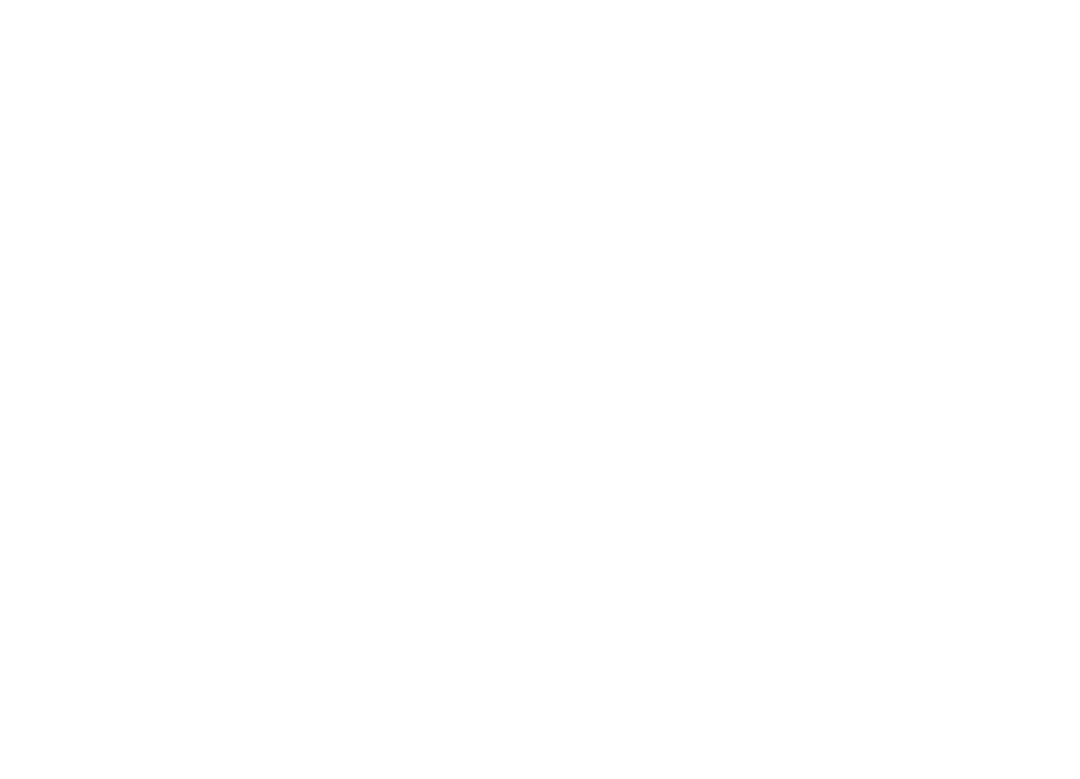

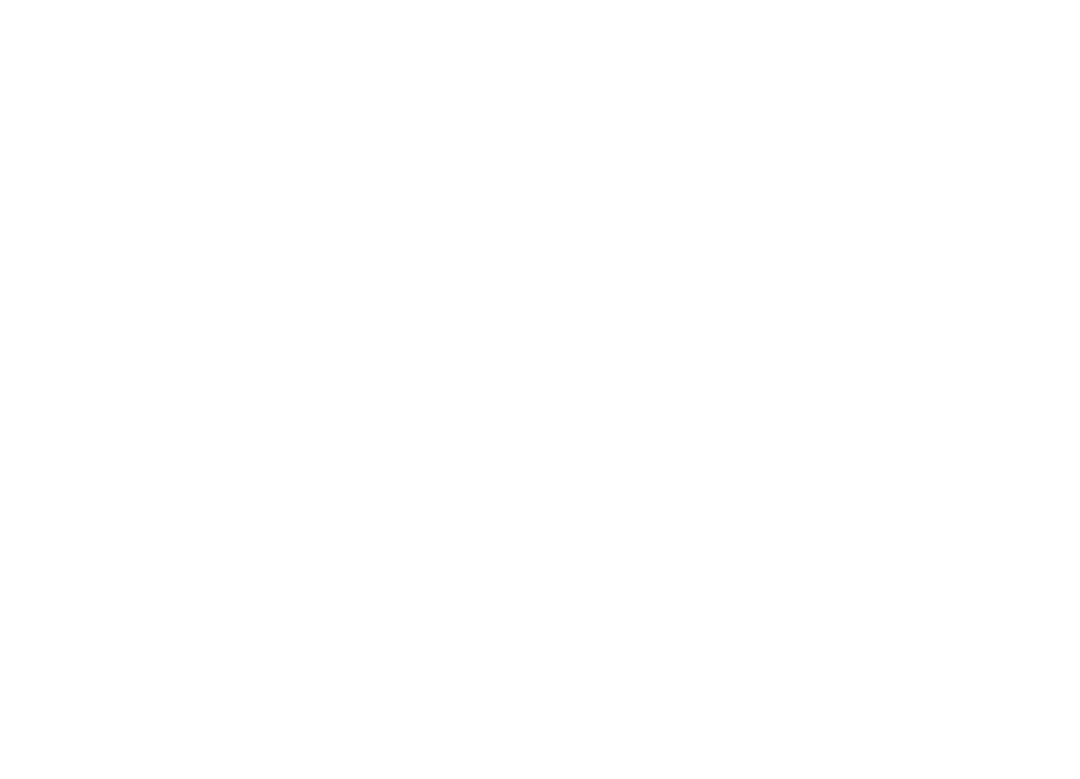

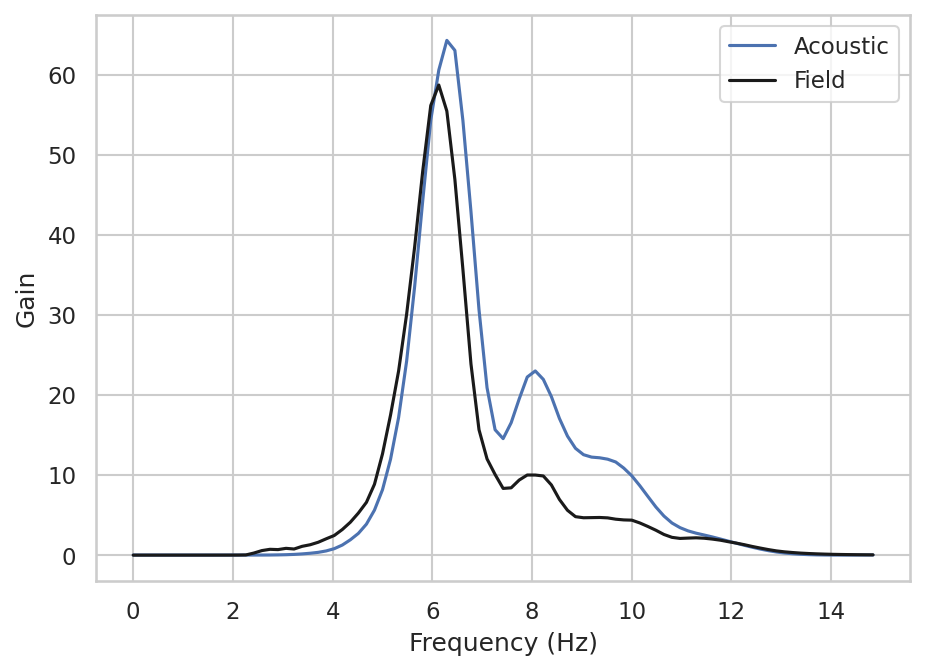

In [287]:
vis.plot_shot(np.concatenate([src_tr_mean_ac, dst_tr_mean], 0), 
              title='Mean synthetic / field', colorbar=True,
              dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_shot(np.concatenate([src_tr_std_ac, dst_tr_std], 0), 
              title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
dictlist = [{'data': src_tr_mean_ac, 'line': 'b', 'label': 'Acoustic'}, 
            {'data': dst_tr_mean, 'line': 'k', 'label': 'Field'}]
vis.plot_spectra_dictlist(dictlist, dt=d.DT, fmax=15)

## Elastic

In [288]:
sorted_fnames_el_moved = [f.replace(root_dataset_syn_el, root_dataset_syn_filt_el) for f in sorted_fnames_el]
loader_src_tr_filt_el = ld.Loader(sorted_fnames_el_moved, par_loader)

path_src_tr_mean = os.path.join(root_dataset_syn_el, 'src_tr_mean.npy')
path_src_tr_std = os.path.join(root_dataset_syn_el, 'src_tr_std.npy')
if not os.path.exists(path_src_tr_mean):
    src_tr_mean_el, src_tr_std_el = get_loader_stats(loader_src_tr_filt_el, dat_src.shape)
    np.save(path_src_tr_mean, src_tr_mean_el)
    np.save(path_src_tr_std, src_tr_std_el)
else:
    src_tr_mean_el = np.load(path_src_tr_mean)
    src_tr_std_el = np.load(path_src_tr_std)

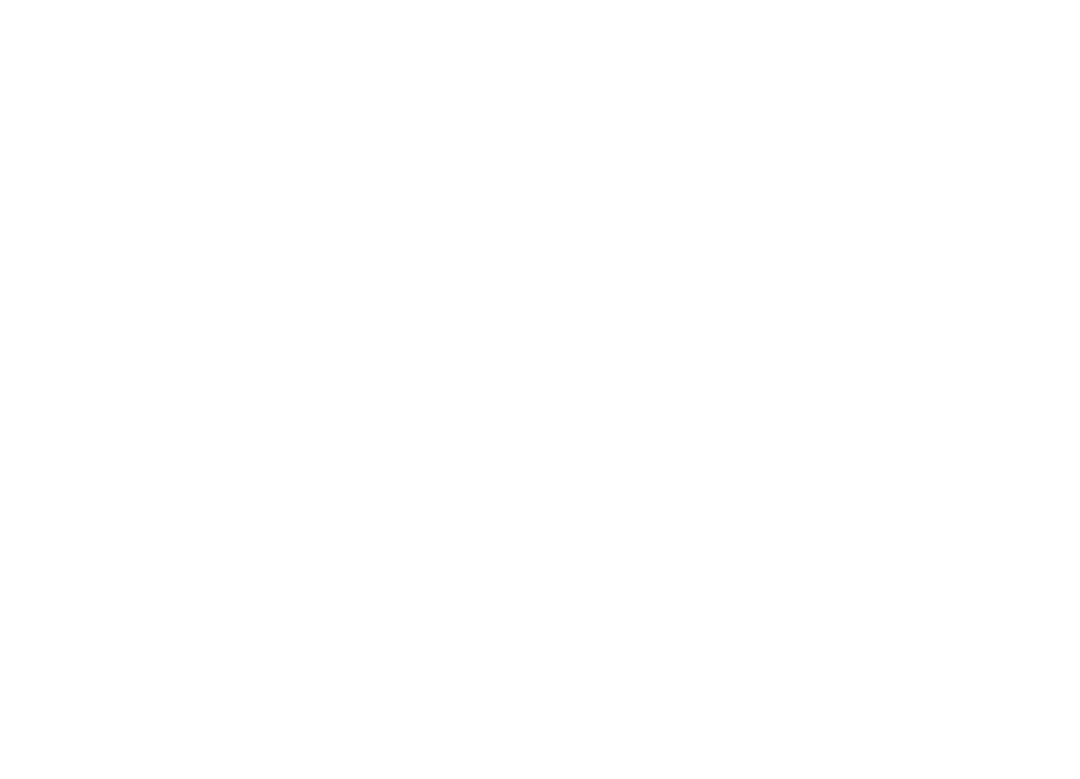

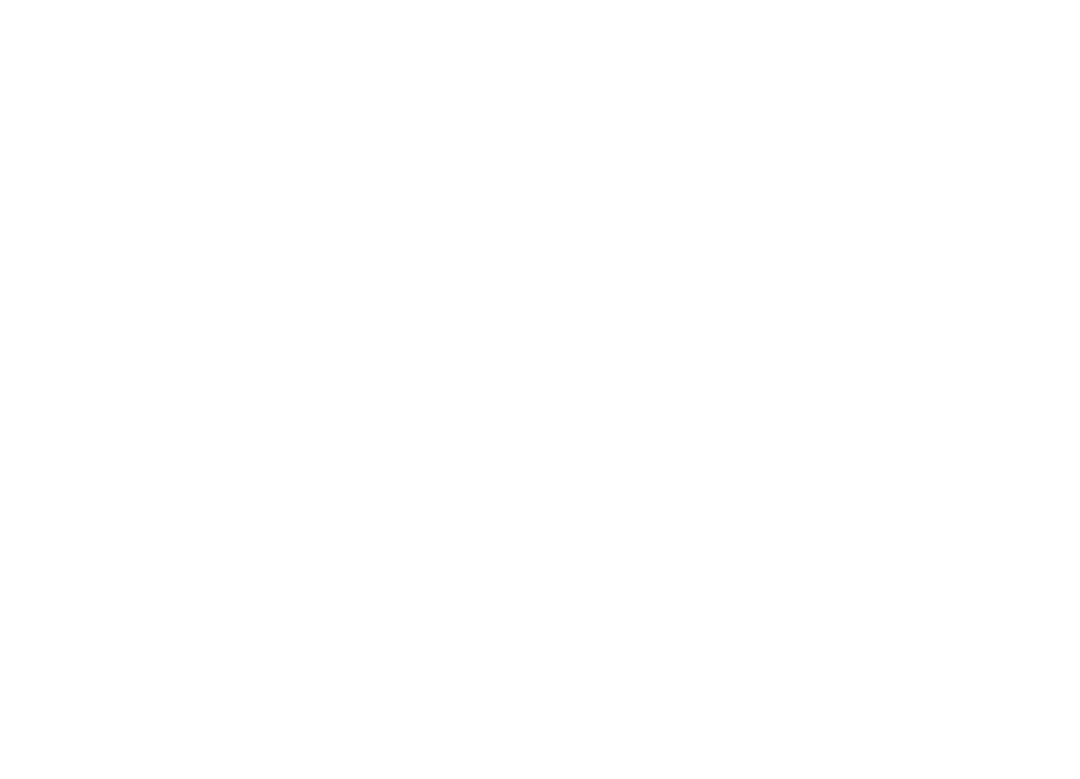

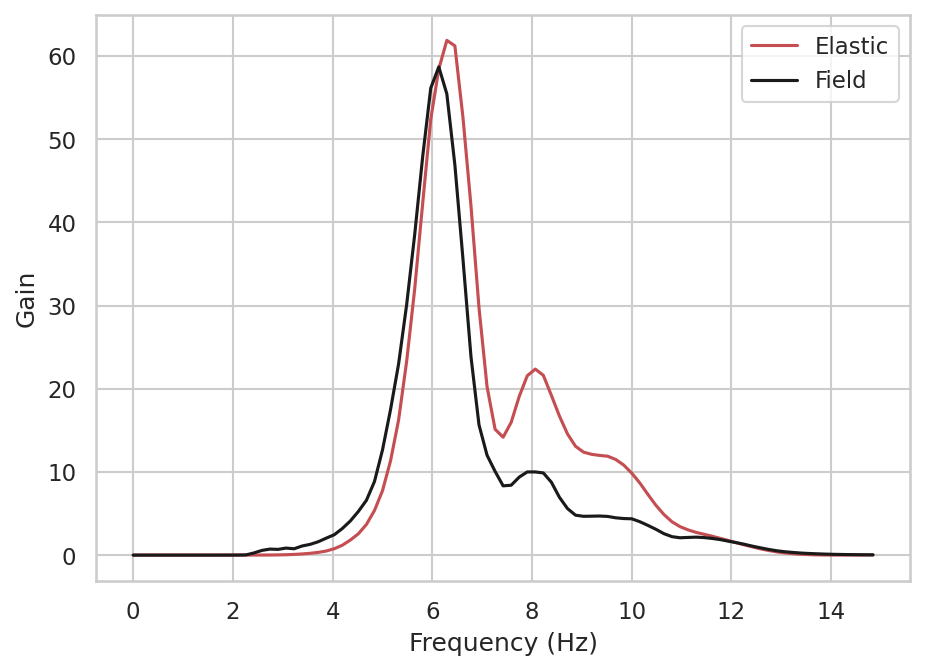

In [289]:
vis.plot_shot(np.concatenate([src_tr_mean_el, dst_tr_mean], 0), 
              title='Mean synthetic / field', colorbar=True,
              dt=d.DT, vmin=-0.1, vmax=0.1)
vis.plot_shot(np.concatenate([src_tr_std_el, dst_tr_std], 0), 
              title='STD synthetic / field', dt=d.DT, vmin=-0.1, vmax=0.1)
dictlist = [{'data': src_tr_mean_el, 'line': 'r', 'label': 'Elastic'}, 
            {'data': dst_tr_mean, 'line': 'k', 'label': 'Field'}]
vis.plot_spectra_dictlist(dictlist, dt=d.DT, fmax=15)

## Compare acoustic and elastic

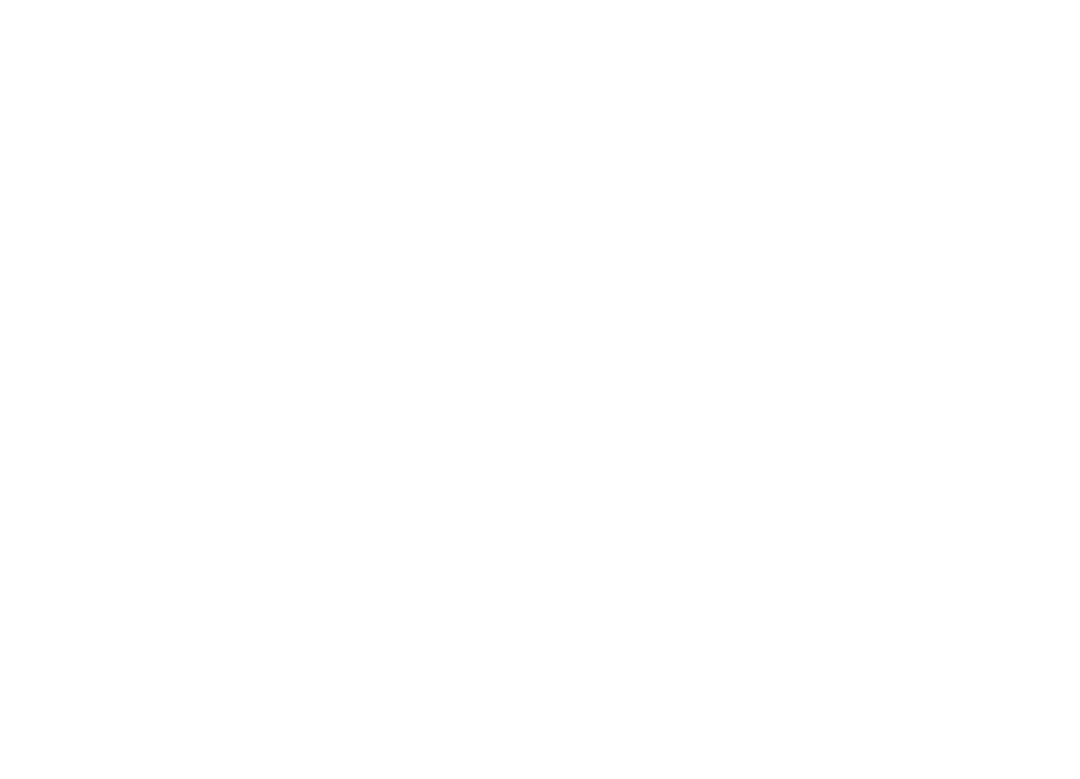

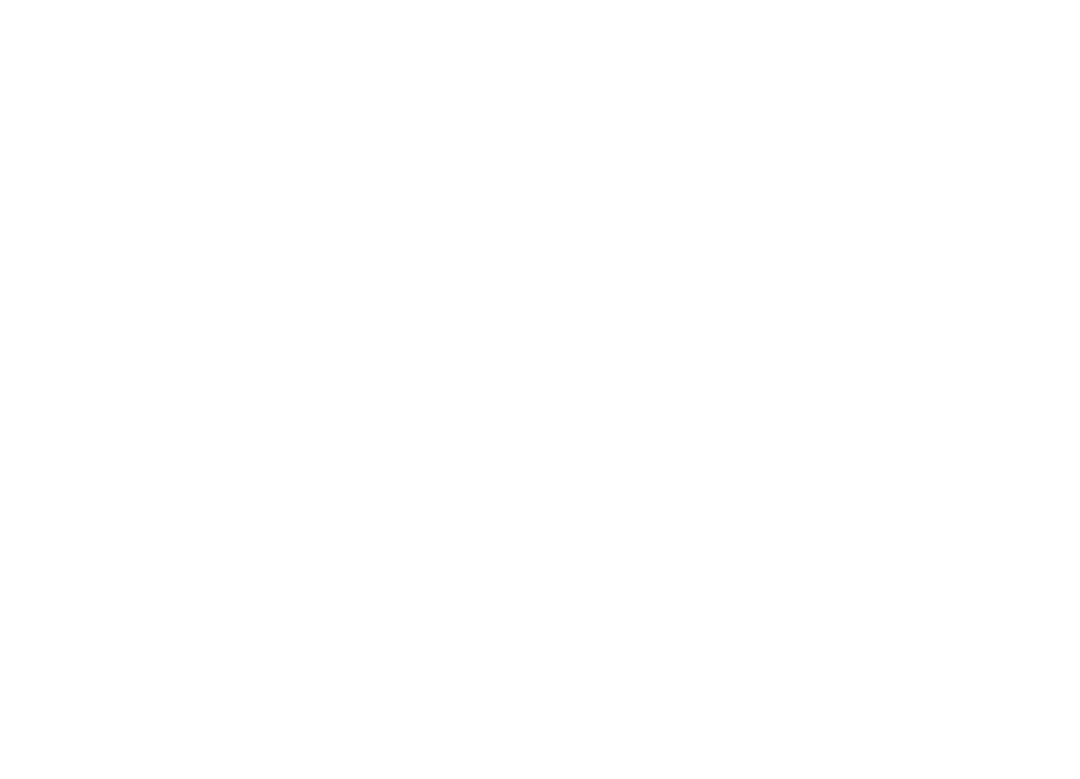

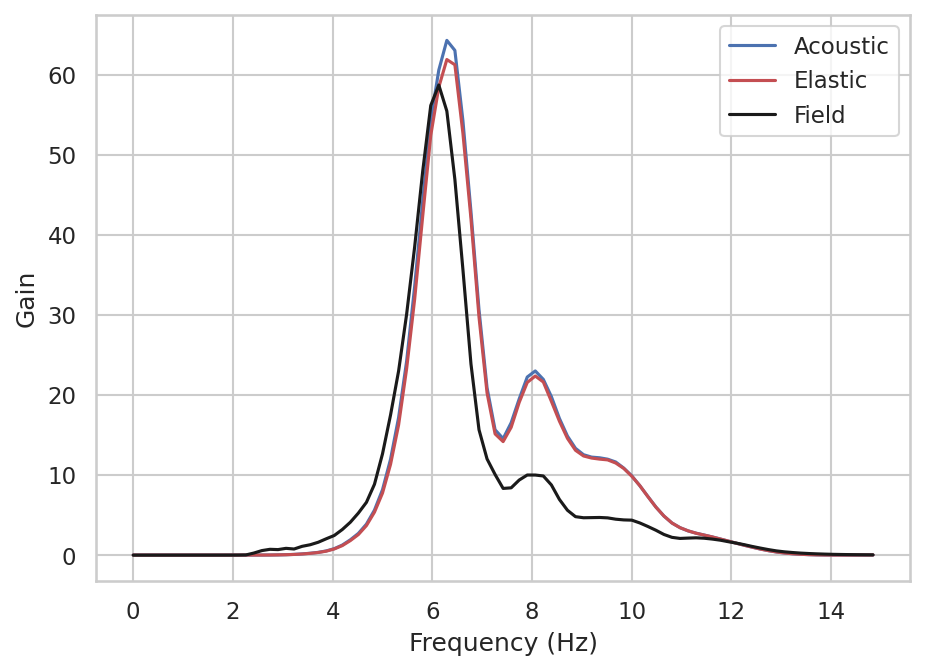

In [290]:
# importlib.reload(vis)
vis.plot_shot(np.concatenate([src_tr_mean_ac, src_tr_mean_el, dst_tr_mean], 0), 
              title='Mean acoustic / elastic / field', colorbar=True,
              dt=d.DT, vmin=-0.01, vmax=0.01)
vis.plot_shot(np.concatenate([src_tr_std_ac, src_tr_std_el, dst_tr_std], 0), 
              title='STD acoustic / elastic / field', dt=d.DT, vmin=-0.1, vmax=0.1)

dictlist = [{'data': src_tr_mean_ac, 'line': 'b', 'label': 'Acoustic'}, 
            {'data': src_tr_mean_el, 'line': 'r', 'label': 'Elastic'}, 
            {'data': dst_tr_mean, 'line': 'k', 'label': 'Field'}]
vis.plot_spectra_dictlist(dictlist, dt=d.DT, fmax=15)
# vis.plot_spectra_dictlist(dictlist, dt=d.DT, fmax=15, phase=True)

In [291]:
# d_syn.save_folder = './test/'
# d_syn.PHYSICS = 2
# d_syn.forward(api.Model(*make_vp_vs_rho(other_models[12]), dx), src_syn_ac, rec_syn, 'mpirun -np 4')

In [292]:
# shots, fnames = d_syn.get_shots(return_filenames=True)
# vis.plot_shot(np.concatenate(shots, 0), pclip=0.1)

In [293]:
# d_syn.parser_report()

In [294]:
# shots, fnames = d_syn.get_snapshots(return_filenames=True)
# print(len(shots), shots[0].shape)
# vis.plot_shot(shots[1][:, 0, :])

In [295]:
# d_syn.save_folder = './test/'
# d_syn.PHYSICS = 2
# d_syn.NPROCX = 16
# d_syn.NPROCY = 2
# d_syn.DT = d.DT / 8
# d_syn.NT = d.NT * 8

# import scipy
# fine_vp = scipy.ndimage.zoom(other_models[model_id], 4)
# print(fine_vp.shape)
# fine_model = api.Model(*make_vp_vs_rho(fine_vp), dx // 4)
# d_syn.forward(fine_model, src_syn, rec_syn, 'mpirun -np 32')

In [146]:
# shots, fnames = d_syn.get_shots(return_filenames=True)
# vis.plot_shot(np.concatenate(shots, 0), pclip=0.1)

# Create limited datasets extracted from the main one

In [147]:
# # importlib.reload(sd)
# tag = 'ac'
# roots = {'el': root_dataset_syn_filt_el, 'ac': root_dataset_syn_filt_ac}
# for i in [32, 64, 128, 256, 512]:
#     src = roots[tag]
#     dst = roots[tag].replace(f"1024_filt_{tag}_vel", f"{i}_filt_{tag}_vel/")
#     os.makedirs(dst, exist_ok=True)
#     os.makedirs(os.path.join(dst, 'train/raw/'), exist_ok=True)
#     sd.cmd(f'cp -r {os.path.join(src, "test")} {dst}')
#     sd.cmd(f'cp -r {os.path.join(src, "val")} {dst}')
#     rand_models = np.load(os.path.join(src, 'rand_models.npy'))
#     cmd = 'cp ' + src + '/train/raw/model_{0..' + str(i) + '}_* ' + dst + 'train/raw/'
# #     sd.cmd(cmd)

cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/test /data/oleg/data/test_syn_32_filt_ac_vel
cp -r /data/oleg/data/test_syn_32_filt_ac_vel/val /data/oleg/data/test_syn_32_filt_ac_vel


## (after) ML code was run

Copy previously created cube*.npy files when filtered data < 4 Hz to new folders

In [ ]:
# tag = 'el'
# fmax = '4'
# roots = {'el': root_dataset_syn_filt_el, 'ac': root_dataset_syn_filt_ac}
# for i in [32, 64, 128, 256, 512, 1024]:
#     src = roots[tag].replace(f"_filt_{tag}_1024", f"_filt_{tag}_{i}/")
#     dst = roots[tag].replace(f"_filt_{tag}_1024", f"_filt{fmax}_{tag}_{i}/")
#     os.makedirs(dst, exist_ok=True)
#     sd.cmd(f"cp {os.path.join(src, 'cube*.npy')} {dst}")

Delete that old cube files

In [ ]:
# for i in [32, 64, 128, 256, 512, 1024]:
#     src = roots[tag].replace(f"_filt_{tag}_1024", f"_filt_{tag}_{i}/")
#     sd.cmd(f"rm {os.path.join(src, 'cube*.npy')}")